#### The purpose of this script is to find gene clusters that change differentially during reprogramming. The following is done: 
* Louvain clustering of genes;
* K-means clustering of genes; 
    * Euclidean distance

All of these using all expressed genes (in > 50 cells) among BL neural cells only. 

** As per Gary's suggestion, I'll perform Chi-square test to filter out genes that are not significantly enriched in any cluster of cells.  **

I'll make cutoffs on p-values for the Chi-Square test and compare the genes past filtering with the 2500 HVGs from scanpy. 


# 0 Loading packages <a name="loading"></a> 

In [1]:
import sys
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_TOC_PAGA/bin/python
['/home2/s418610/jupyter_notebooks/Invivo_neuronal_reprogramming/Cluster_with_10x/Remapped_10X_data/Harmony.4/PAGA_TI', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python37.zip', '/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7', '/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/lib-dynload', '/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages/IPython/extensions', '/home2/s418610/.ipython']
3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import seaborn as sb

import scanpy as sc
import harmonypy as hm

import anndata
import pickle

In [3]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [4]:
from scipy.stats import chi2_contingency

In [5]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [6]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('sklearn', sklearn.__version__)
print('statsmodels', sm.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

sc.logging.print_versions()

!date +%F

numpy 1.17.2
pandas 0.25.2
scipy 1.3.1
sklearn 0.21.3
statsmodels 0.10.1
matplotlib 3.0.3
seaborn 0.9.0
scanpy==1.4.5.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
2020-04-28


# 1 Load data

In [1]:
# A sub-directory for saving intermediate data for organized pipeline v1
data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/'
gene_data_dir = data_dir + 'Gene_clusters/'

out_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/outs/'
python_dir = data_dir + 'Python_objects/'

In [8]:
neural_data_dir = data_dir + 'NeuralOnly/'

In [8]:
# Start here if using Main Trajectory cells (BL neural cells excluding oligodendrocyte cluster)
adata_experiment_neural_MT = sc.read(data_dir+'BL41-42Only_NeuralOnly_MTOnly_postFiltering_log_pcs50_Harmony_louvain_anno_pseudotime.h5ad')
adata_neural_tmp = adata_experiment_neural_MT.copy()

In [9]:
adata_neural_tmp

AnnData object with n_obs × n_vars = 4879 × 2499 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'diffmap_evals', 'iroot', 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_r1.0', 'umap'
    obsm: 'Harmony', 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

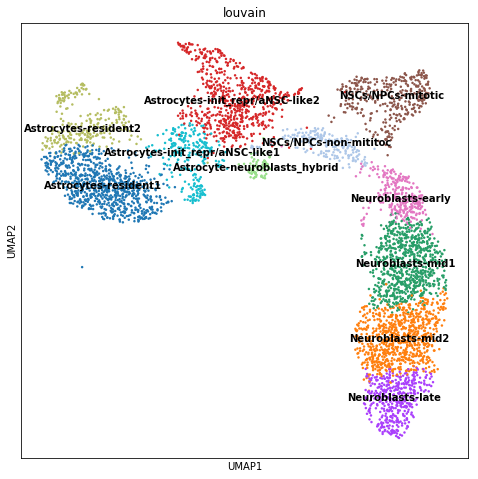

In [10]:
sc.pl.umap(adata_neural_tmp, color='louvain', legend_loc='on data')

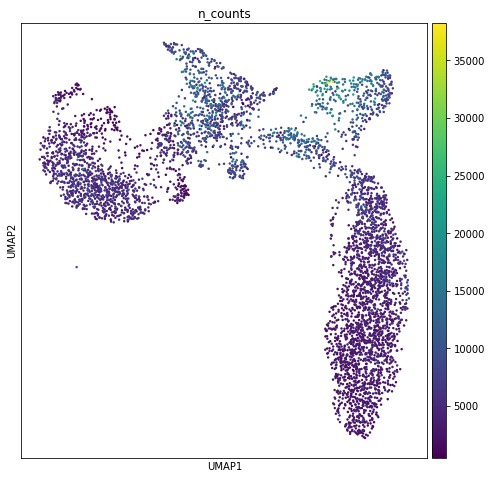

In [11]:
sc.pl.umap(adata_neural_tmp, color='n_counts', legend_loc='on data')

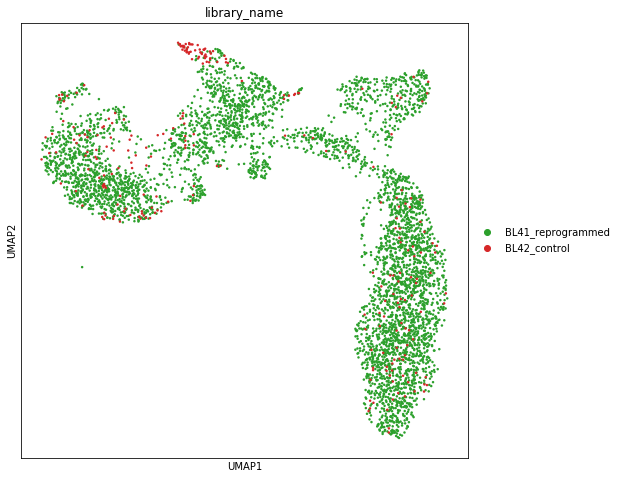

In [12]:
sc.pl.umap(adata_neural_tmp, color=['library_name'])

### Re-calculate HVGs

In [13]:
# Load BL41 and BL42 with 10X datasets (output file of cellranger count aggr)
adata = sc.read_10x_h5('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/BL41-42_with_10X/1.3M_brain_11_51/aggr_10x/outs/filtered_feature_bc_matrix.h5')

reading /project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/BL41-42_with_10X/1.3M_brain_11_51/aggr_10x/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


In [14]:
# The combined dataset has 33145 cells, and 31055 genes
assert adata.X.shape == (33145, 31055)

In [15]:
adata = adata[adata_neural_tmp.obs.index,:]

In [16]:
adata.obs = adata_neural_tmp.obs

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
adata.var_names_make_unique()

In [18]:
adata

AnnData object with n_obs × n_vars = 4879 × 31055 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome'

In [19]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 5 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=50)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31055
filtered out 18565 genes that are detected in less than 50 cells
Number of genes after cell filter: 12490


#### Use chi-square test to remove stochastic (though variable) genes

In [20]:
cluster_size = adata.obs['louvain'].value_counts()

In [21]:
cluster_size.index

CategoricalIndex(['Astrocytes-resident1', 'Neuroblasts-mid2',
                  'Neuroblasts-mid1', 'Astrocytes-init_repr/aNSC-like2',
                  'Neuroblasts-late', 'NSCs/NPCs-mitotic', 'Neuroblasts-early',
                  'Astrocytes-init_repr/aNSC-like1', 'Astrocytes-resident2',
                  'NSCs/NPCs-non-mititoc', 'Astrocyte-neuroblasts_hybrid'],
                 categories=['Astrocytes-resident1', 'Neuroblasts-mid2', 'Neuroblasts-mid1', 'Astrocytes-init_repr/aNSC-like2', 'Neuroblasts-late', 'NSCs/NPCs-mitotic', 'Neuroblasts-early', 'Astrocytes-resident2', ...], ordered=False, dtype='category')

In [47]:
# gene = adata.var.index[0]
df_tmp = pd.DataFrame(adata.obs['louvain'])
genes_keep = []
for gene in adata.var.index: 
    df_tmp['gene_expressed'] = adata[:,gene].X > 0

#    df_tmp[df_tmp['gene_expressed']]['louvain'].value_counts()[expression_table.index]

    expression_table = pd.DataFrame(df_tmp[df_tmp['gene_expressed']]['louvain'].value_counts()[cluster_size.index])

    expression_table.columns = ['positive_cells']

    expression_table['negative_cells'] = cluster_size.values - expression_table['positive_cells']

    if expression_table['negative_cells'].sum() == 0:
        genes_keep.append((gene, 1)) 
        continue
#    expression_table

    # Make contigency table with the format:
    # [[queried cluster pos, rest clusters pos],
    #  [queried cluster neg, rest clusters neg]]
    # queried_cluster = '0'

    
    obs = np.array([expression_table['positive_cells'], expression_table['negative_cells']])

    _, p_val, _, _ = chi2_contingency(obs)

    p_val_adj = p_val * adata.X.shape[1]


#    if p_val_adj < 0.05:
#        genes_keep.append((gene, p_val_adj))
        
    genes_keep.append((gene, p_val_adj))

/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


In [48]:
len(genes_keep)

12490

In [49]:
genes_keep[-5:]

[('Tmlhe', 0.13656116659935855),
 ('AC149090.1', 1.2207077565245254e-14),
 ('CAAA01118383.1', 3.158753641497707e-59),
 ('Lenti-hGfa-Dlx2-IRES-GFP', 0.0),
 ('tdTomato-WPRE-bGHpA', 1.2011992973288377e-235)]

In [50]:
keep_index = [gene for gene, p_val_adj in genes_keep]
p_values_adj = [p_val_adj for gene, p_val_adj in genes_keep]

In [51]:
chi_result = pd.DataFrame(data={'gene': keep_index, 'p_values_adj': p_values_adj})

In [52]:
chi_result['log10_p_values'] = np.log10(chi_result['p_values_adj'])

/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
# for i in [-1.3, -2, -3, -4, -5, -6, -7, -8, -9, -10]:
for i in range(-5, -150, -5):
    print('{} genes have log10 p value less than {}.'.format(sum(chi_result['log10_p_values'] < i), i))

10802 genes have log10 p value less than -5.
9835 genes have log10 p value less than -10.
9034 genes have log10 p value less than -15.
8293 genes have log10 p value less than -20.
7621 genes have log10 p value less than -25.
7097 genes have log10 p value less than -30.
6567 genes have log10 p value less than -35.
6069 genes have log10 p value less than -40.
5625 genes have log10 p value less than -45.
5240 genes have log10 p value less than -50.
4895 genes have log10 p value less than -55.
4577 genes have log10 p value less than -60.
4282 genes have log10 p value less than -65.
4018 genes have log10 p value less than -70.
3786 genes have log10 p value less than -75.
3542 genes have log10 p value less than -80.
3334 genes have log10 p value less than -85.
3125 genes have log10 p value less than -90.
2939 genes have log10 p value less than -95.
2775 genes have log10 p value less than -100.
2606 genes have log10 p value less than -105.
2445 genes have log10 p value less than -110.
2321 ge

In [54]:
adata = adata[:,chi_result['log10_p_values']<-110]

In [55]:
adata

View of AnnData object with n_obs × n_vars = 4879 × 2445 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [66]:
adata.var['p_val_adj'] = chi_result['p_values_adj'][chi_result['log10_p_values']<-110]

In [67]:
#Keep the count data in a counts layer
adata.layers['counts'] = adata.X.copy()

In [68]:
# Natural log-transform the data
sc.pp.log1p(adata)

In [69]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [70]:
# n_genes = 2500 # This recovers 22 out of 38 marker genes
# n_genes = 5000 # This recovers 26 out of 38 marker genes
# n_genes = 10000 # This recovers 28 out of 38 marker genes
# n_genes = 15218 # All genes expressed in > 10 cells
n_genes = adata.X.shape[1] # Keep all genes that passed 50 cell filter and are differentially enriched between cell clusters

sc.pp.recipe_zheng17(adata, n_top_genes = n_genes, log=False) # log=False as adata.X is already log-transformed

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [71]:
adata

AnnData object with n_obs × n_vars = 4879 × 2445 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts'
    uns: 'log1p'
    layers: 'counts'

# 2-A Perform Louvain clustering on genes

In [77]:
# Construct a new AnnData, for all 2499 HVGs, but revert to raw data (log1p of raw counts) 
# for downstream clustering

# Genes are on rows, and cells on columns
adata_genes = anndata.AnnData(X=adata.X.T, 
                             obs=adata.var, 
                             var=adata.obs)

In [78]:
adata_genes

AnnData object with n_obs × n_vars = 2445 × 4879 
    obs: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts'
    var: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'

In [79]:
# Calculate how many BL neural cells (5056 total) express each gene; a useful metric downstream
adata_genes.obs['n_cells_BL_neural'] = (adata_genes.X>0).sum(axis=1)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


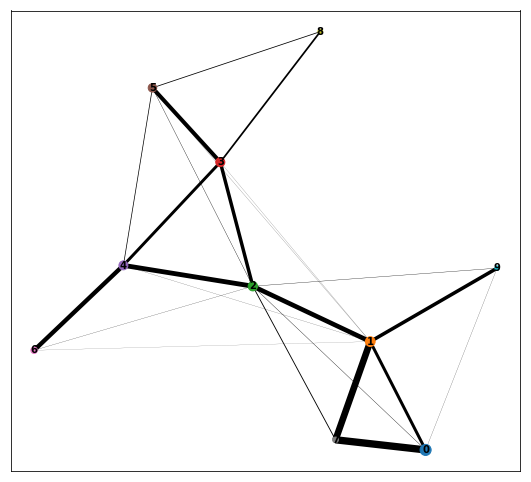

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [80]:
# Perform PCA and Louvain clustering for the 2499 genes
sc.tl.pca(adata_genes, n_comps=50)

sc.pp.neighbors(
    adata_genes,
    use_rep='X_pca',  
#    use_rep='Harmony',  
#    random_state=random_seed
)

sc.tl.louvain(
    adata_genes,
#    resolution=0.50,
#   resolution=0.70,
    resolution=1.00,
#    resolution=1.50,
    #    random_state=random_seed
)

sc.tl.paga(
    adata_genes,
    groups='louvain',  
)

sc.pl.paga(
    adata_genes, 
    color=['louvain'], 
    use_raw=True,
#    use_raw=False,
#    layout='fa', 
    layout='fr', 
    threshold=0.01, 
    node_size_scale=0.5,
    node_size_power=0.9, 
#    random_state=random_seed, 
)

sc.tl.umap(
    adata_genes,
    init_pos='paga', 
#    random_state=random_seed,
)

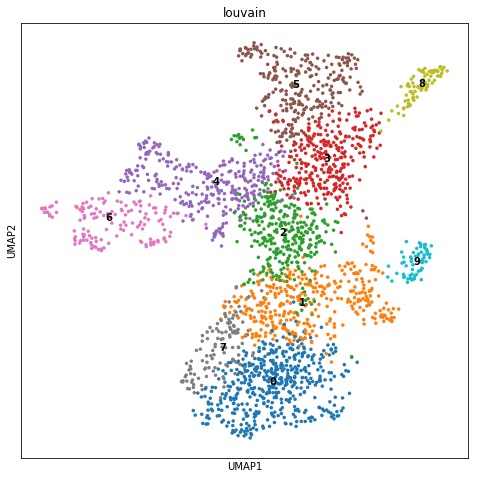

In [81]:
# Plot the genes
sc.pl.umap(adata_genes, color='louvain', legend_loc='on data')

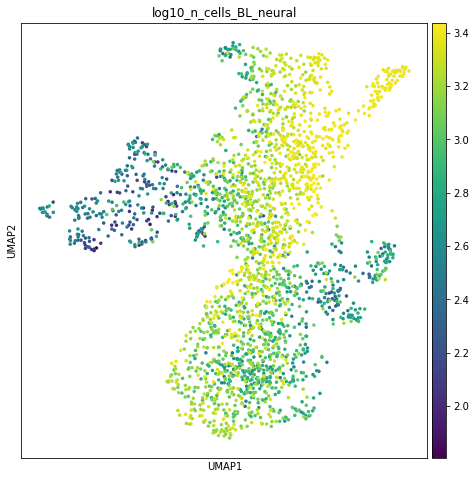

In [82]:
# Plot the genes
adata_genes.obs['log10_n_cells_BL_neural'] = np.log10(adata_genes.obs['n_cells_BL_neural'] + 1)
sc.pl.umap(adata_genes, color='log10_n_cells_BL_neural')

In [83]:
# How many genes are in each cluster? 
louvain_clusters_counter = adata_genes.obs['louvain'].value_counts()
louvain_clusters_counter

0    481
1    364
2    330
3    308
4    299
5    266
6    144
7    115
8     76
9     62
Name: louvain, dtype: int64

In [84]:
# Calculate geometric mean (in form of log1p-transformed read counts) for each cluster of genes
for i in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(i)
    cluster_gene_index = adata_genes.obs[adata_genes.obs['louvain'] == n_cluster_gene].index
    adata_neural_tmp.obs['louvain_cluster_'+n_cluster_gene+'_gene_log_mean'] = adata.raw[:, cluster_gene_index.tolist()].X.sum(axis=1)/louvain_clusters_counter[i]
    adata_neural_tmp.obs['louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean'] = adata[:, cluster_gene_index.tolist()].X.sum(axis=1)/louvain_clusters_counter[i]

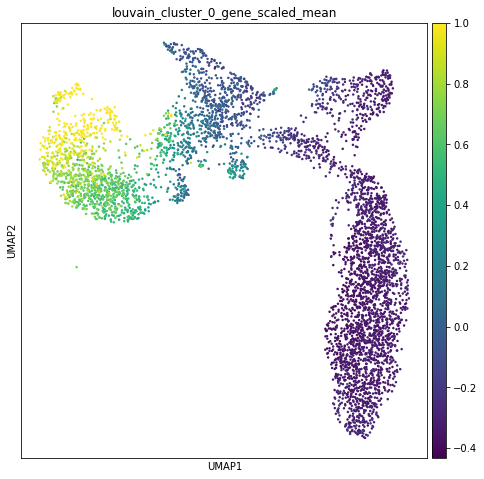

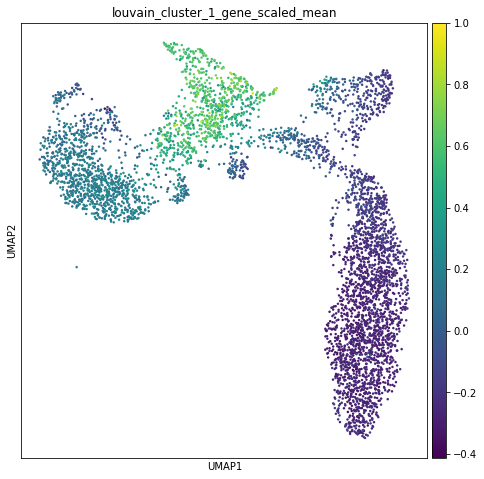

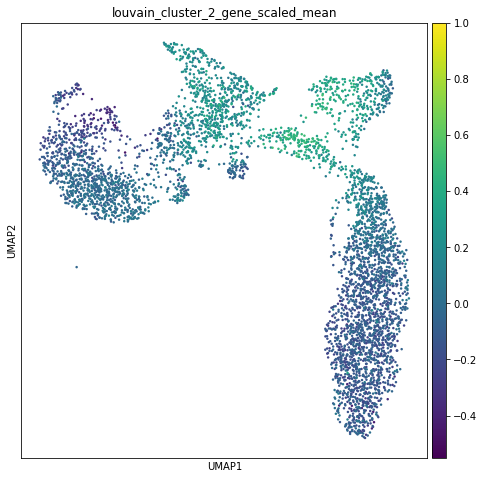

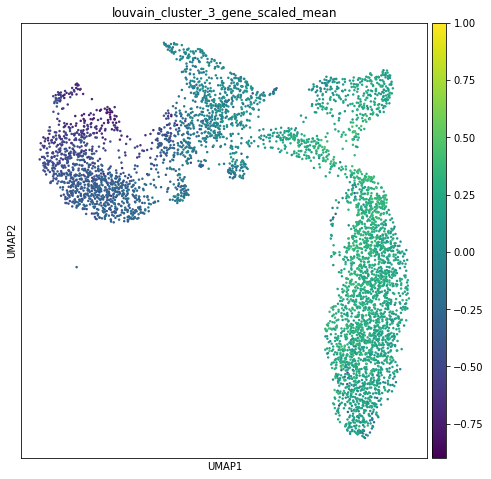

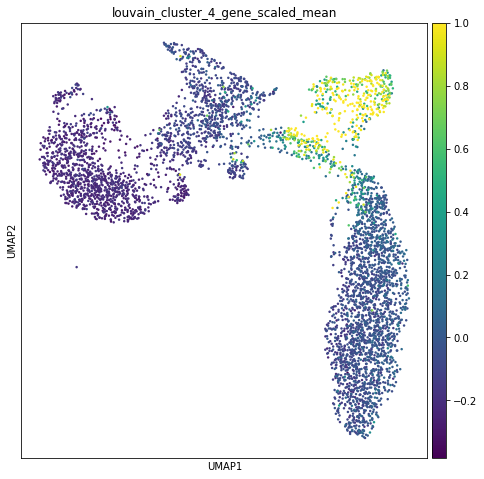

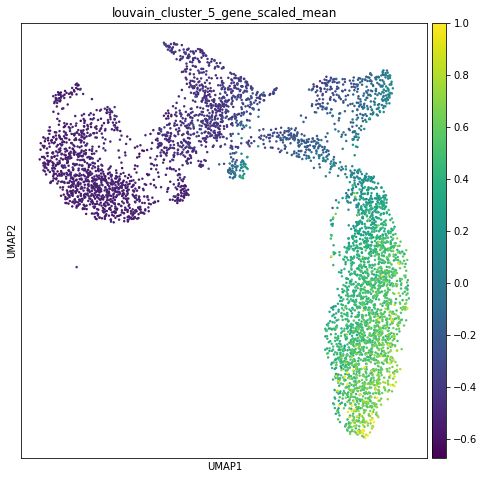

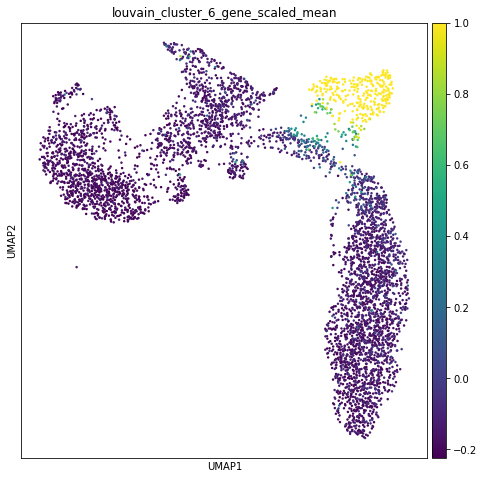

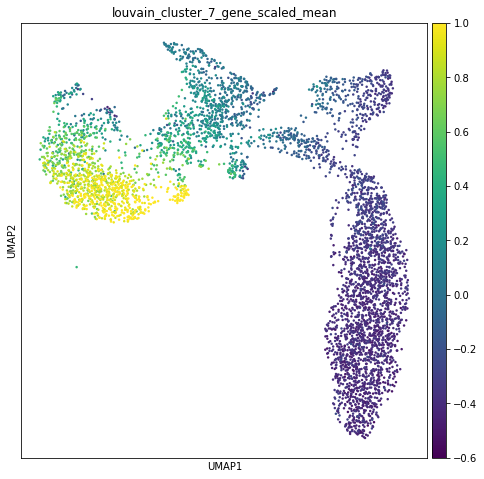

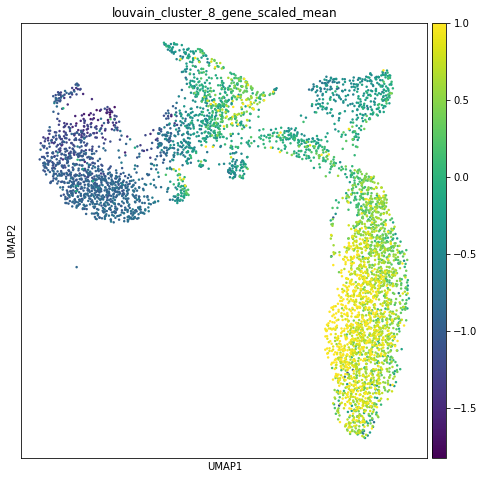

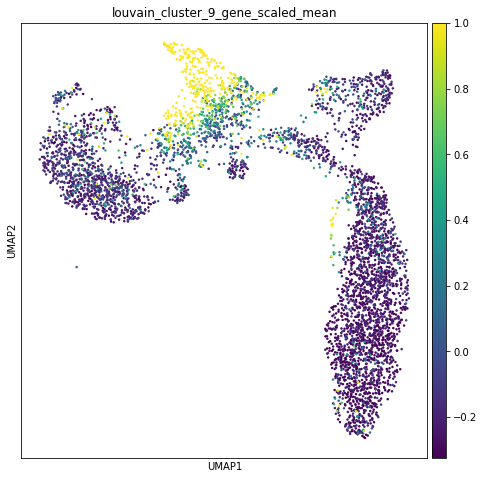

In [85]:
# Plot the scaled mean of each gene cluster on the original BL neural cell map
for n_cluster_gene in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(n_cluster_gene)
    sc.pl.umap(adata_neural_tmp, color='louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean', vmax=1.0)

In [86]:
adata_genes.obs.loc[['Aldh1l1', 'Lenti-hGfa-Dlx2-IRES-GFP', 'Top2a', 'Dlx2', 'Dcx', 'Calb2', 'tdTomato-WPRE-bGHpA']]

gene_ids    feature_types  \
Aldh1l1                         ENSMUSG00000030088  Gene Expression   
Lenti-hGfa-Dlx2-IRES-GFP  Lenti-hGfa-Dlx2-IRES-GFP  Gene Expression   
Top2a                           ENSMUSG00000020914  Gene Expression   
Dlx2                            ENSMUSG00000023391  Gene Expression   
Dcx                             ENSMUSG00000031285  Gene Expression   
Calb2                           ENSMUSG00000003657  Gene Expression   
tdTomato-WPRE-bGHpA            tdTomato-WPRE-bGHpA  Gene Expression   

                                                  genome  n_cells  p_val_adj  \
Aldh1l1                   mm10-3.0.0-Lenti-Dlx2_tdTomato      830        NaN   
Lenti-hGfa-Dlx2-IRES-GFP  mm10-3.0.0-Lenti-Dlx2_tdTomato     2482        NaN   
Top2a                     mm10-3.0.0-Lenti-Dlx2_tdTomato      469        NaN   
Dlx2                      mm10-3.0.0-Lenti-Dlx2_tdTomato     1859        NaN   
Dcx                       mm10-3.0.0-Lenti-Dlx2_tdTomato     2441        NaN   
Calb2                     mm10-3.0.0-Lenti-Dlx2_tdTomato      268        NaN   
tdTomato-WPRE-bGHpA       mm10-3.0.0-Lenti-Dlx2_tdTomato     3257        NaN   

                             n_counts  n_cells_BL_neural louvain  \
Aldh1l1                    750.771545                830       7   
Lenti-hGfa-Dlx2-IRES-GFP  3458.085938               2227       1   
Top2a                      919.314392                469       6   
Dlx2                      1974.760376               1767       5   
Dcx                       3198.672363               2072       5   
Calb2                      258.616119                268       5   
tdTomato-WPRE-bGHpA       4227.144531               2542       1   

                          log10_n_cells_BL_neural  
Aldh1l1                                  2.919601  
Lenti-hGfa-Dlx2-IRES-GFP                 3.347915  
Top2a                                    2.672098  
Dlx2                                     3.247482  
Dcx                                      3.316599  
Calb2                                    2.429752  
tdTomato-WPRE-bGHpA                      3.405346

In [87]:
adata_genes.obs.loc[['Clu', 'Id3', 'Rpl32', 'Egfr', 'Mki67', 'Ccna2', 'Dlx1', 'Dlx2', 'Dcx', 'Dlx6os1']]

gene_ids    feature_types                          genome  \
Clu      ENSMUSG00000022037  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Id3      ENSMUSG00000007872  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Rpl32    ENSMUSG00000057841  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Egfr     ENSMUSG00000020122  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Mki67    ENSMUSG00000031004  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Ccna2    ENSMUSG00000027715  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Dlx1     ENSMUSG00000041911  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Dlx2     ENSMUSG00000023391  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Dcx      ENSMUSG00000031285  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   
Dlx6os1  ENSMUSG00000090063  Gene Expression  mm10-3.0.0-Lenti-Dlx2_tdTomato   

         n_cells  p_val_adj      n_counts  n_cells_BL_neural louvain  \
Clu         1999        NaN   4867.380371               1720       0   
Id3         1272        NaN   2017.230591               1222       7   
Rpl32       4456        NaN  10299.020508               2452       8   
Egfr         804        NaN    770.534546                804       2   
Mki67        396        NaN    719.454224                396       6   
Ccna2        311        NaN    422.989502                311       6   
Dlx1        2303        NaN   2715.518555               2085       5   
Dlx2        1859        NaN   1974.760376               1767       5   
Dcx         2441        NaN   3198.672363               2072       5   
Dlx6os1     2395        NaN   3615.498291               2138       5   

         log10_n_cells_BL_neural  
Clu                     3.235781  
Id3                     3.087426  
Rpl32                   3.389698  
Egfr                    2.905796  
Mki67                   2.598791  
Ccna2                   2.494155  
Dlx1                    3.319314  
Dlx2                    3.247482  
Dcx                     3.316599  
Dlx6os1                 3.330211

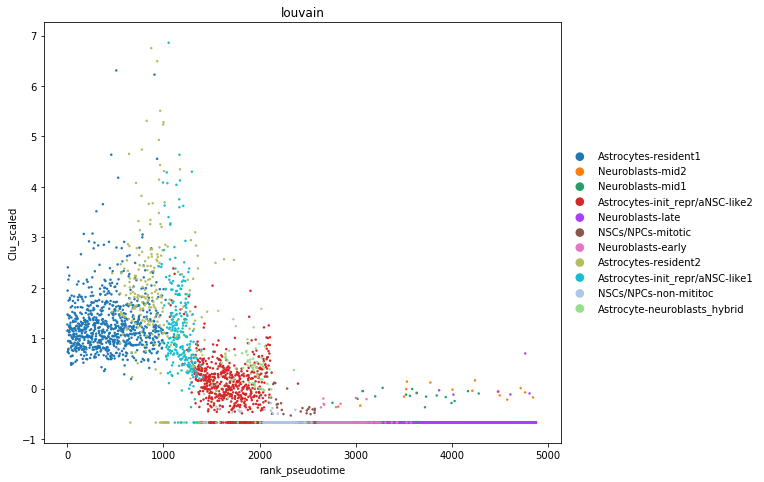

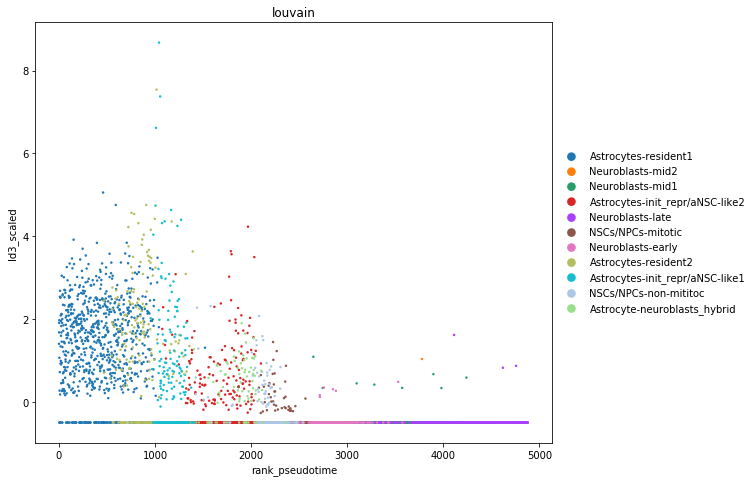

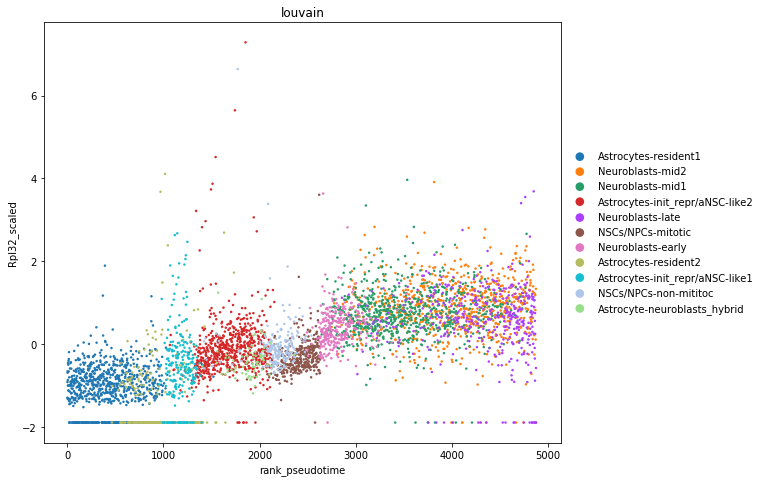

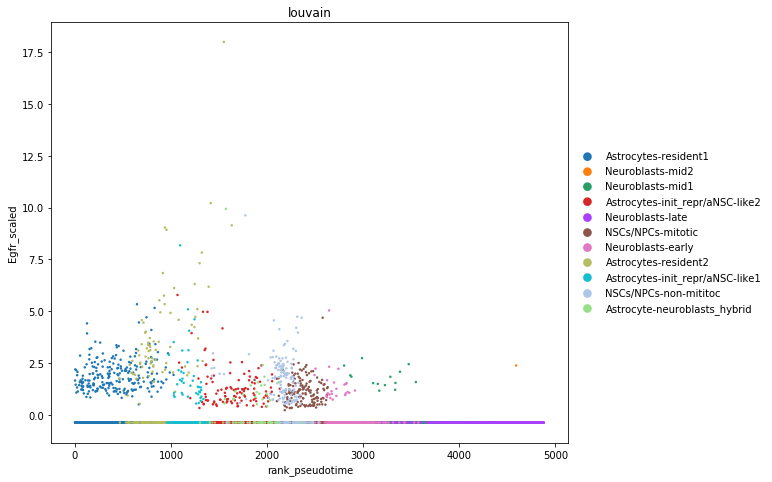

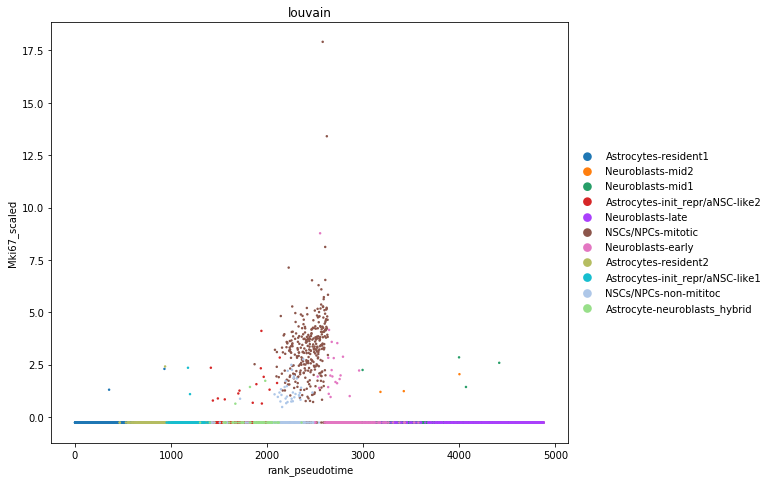

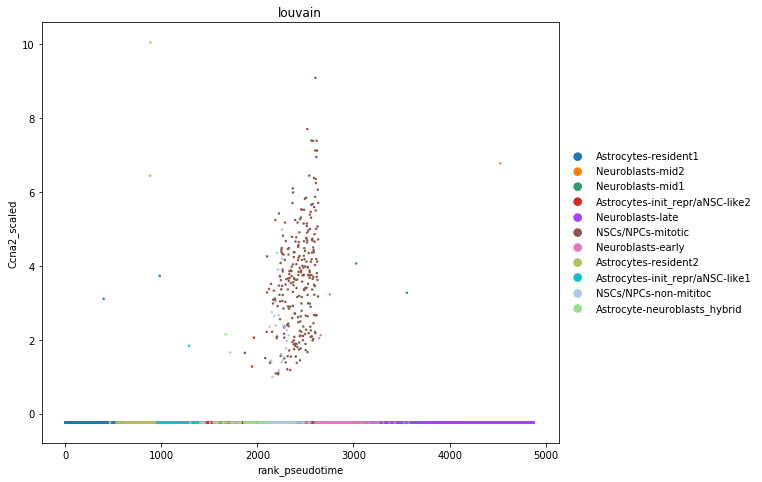

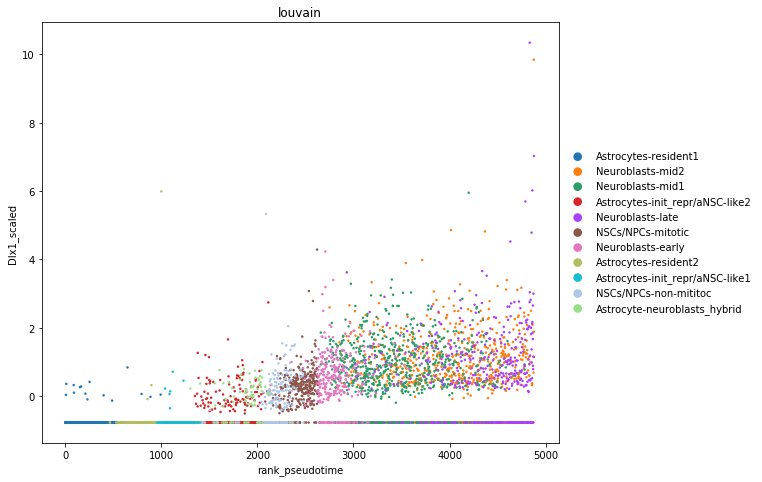

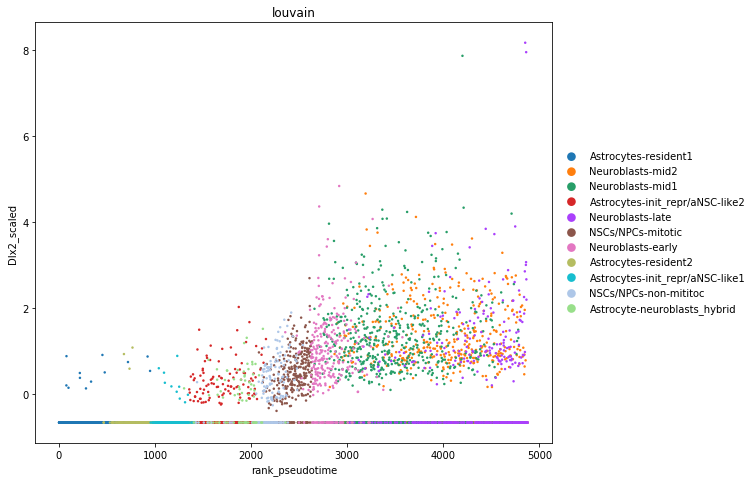

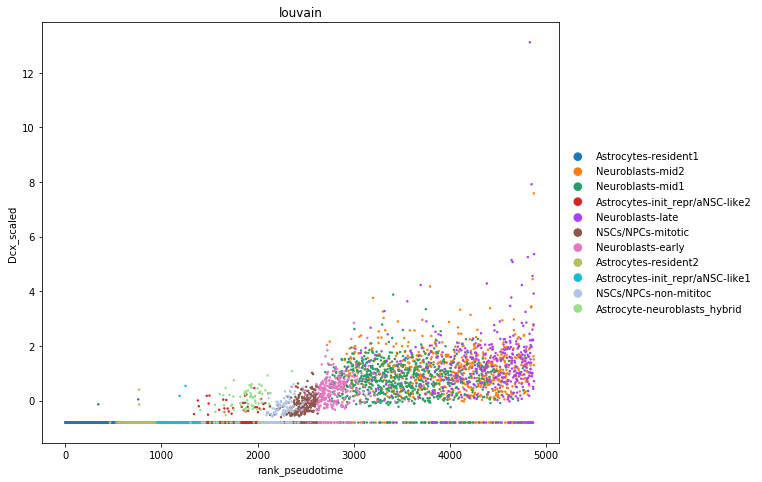

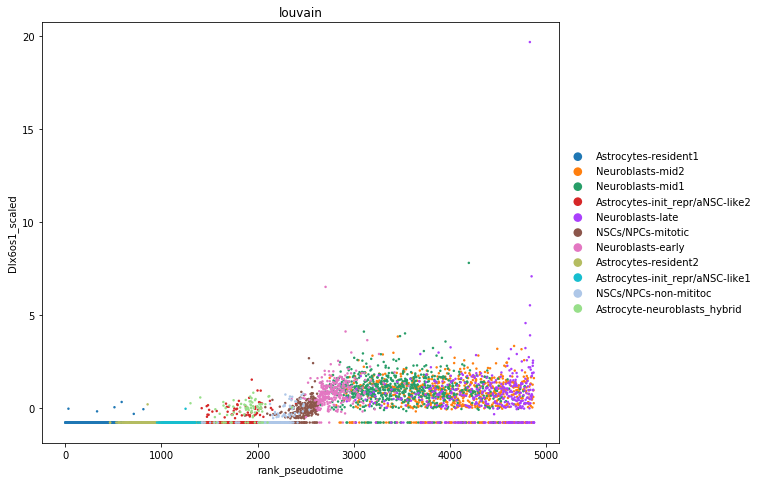

/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


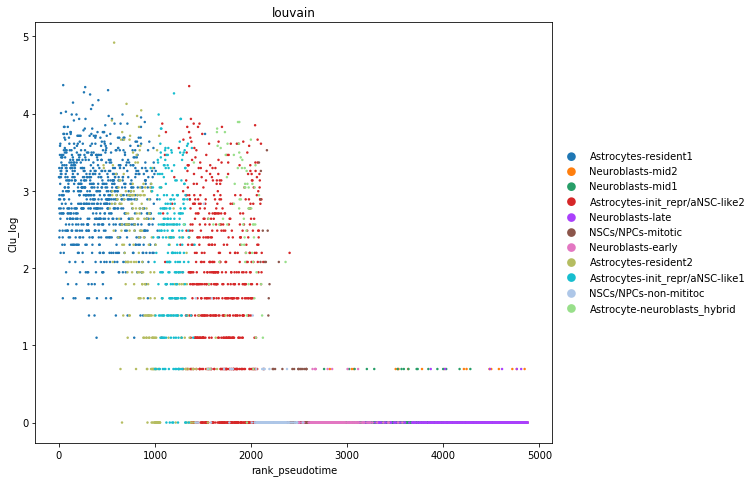

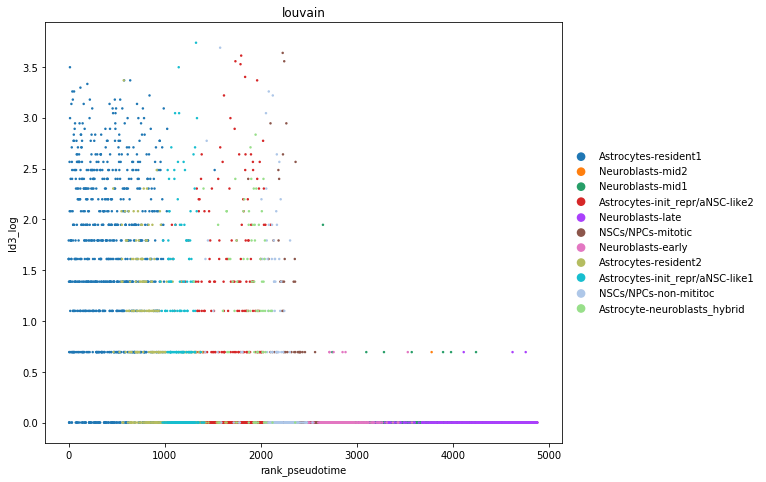

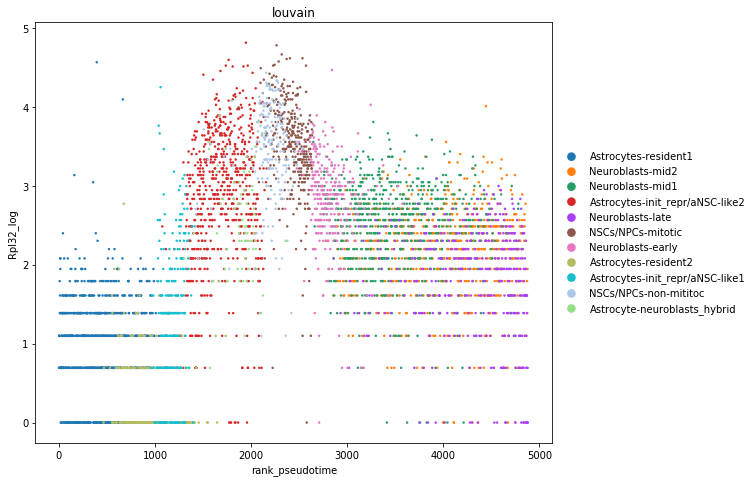

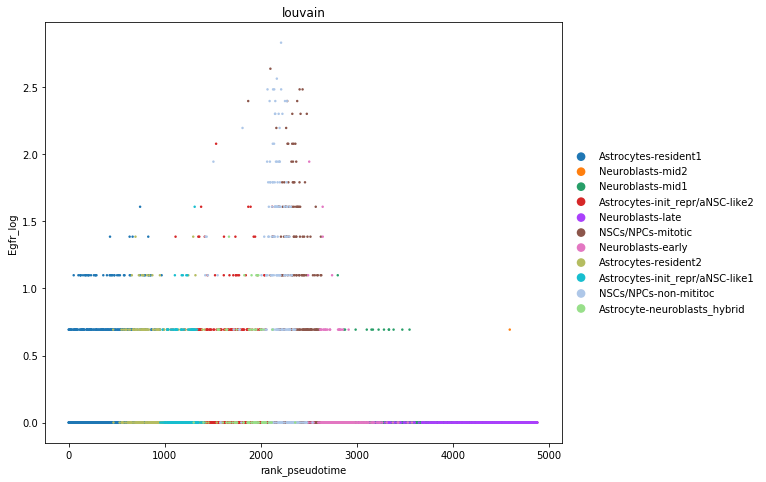

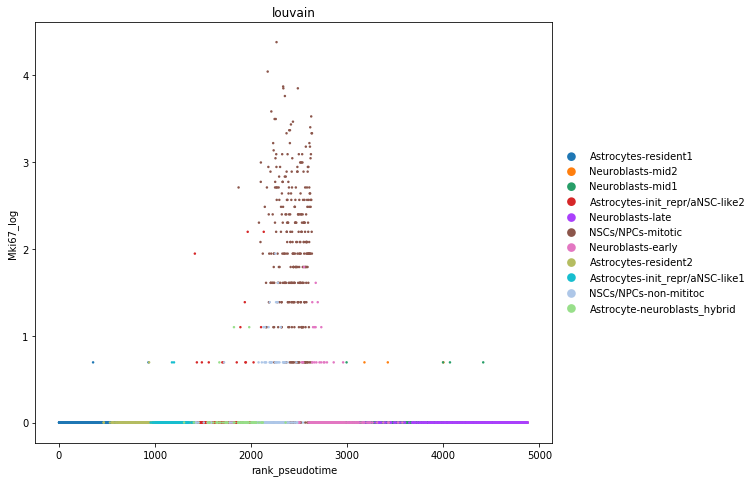

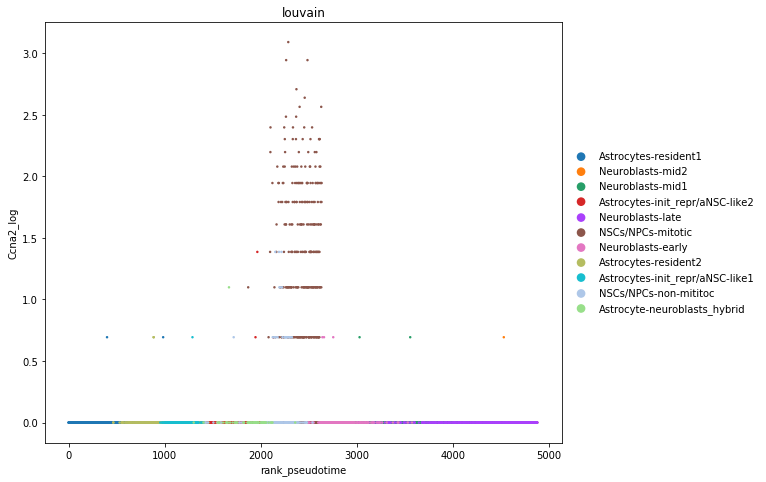

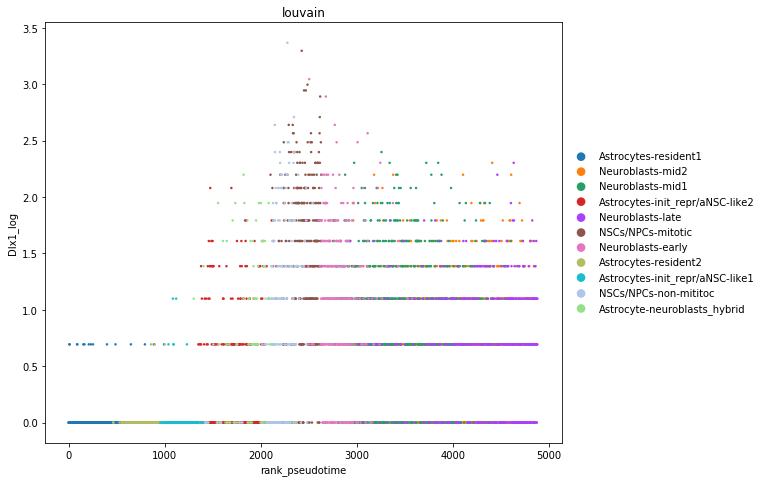

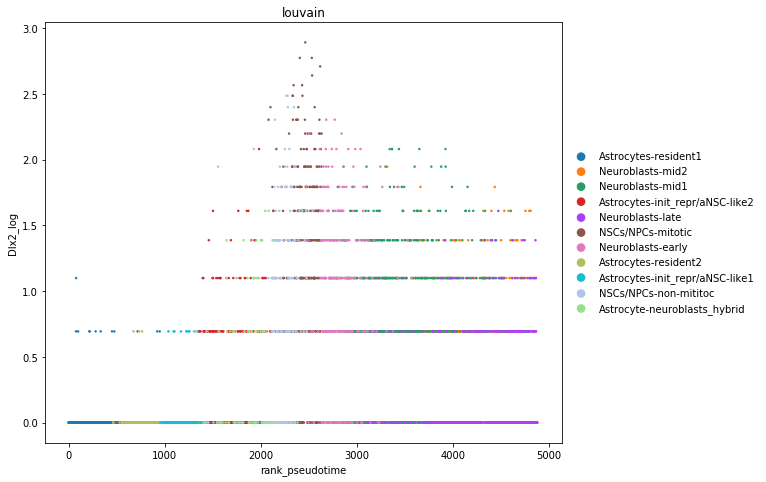

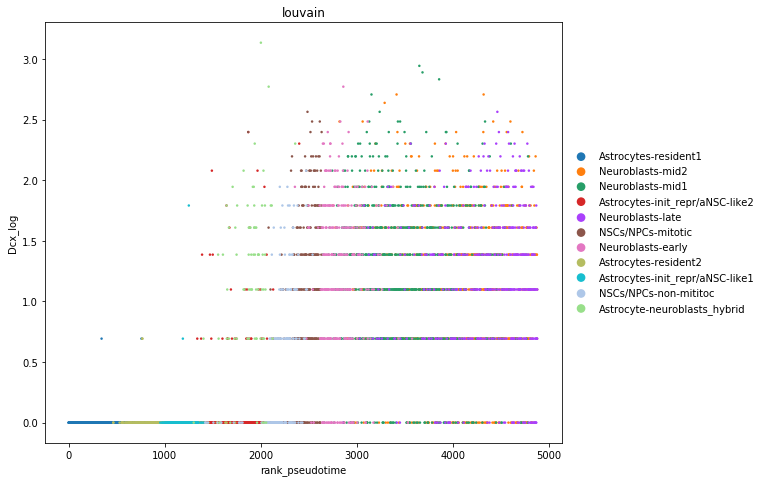

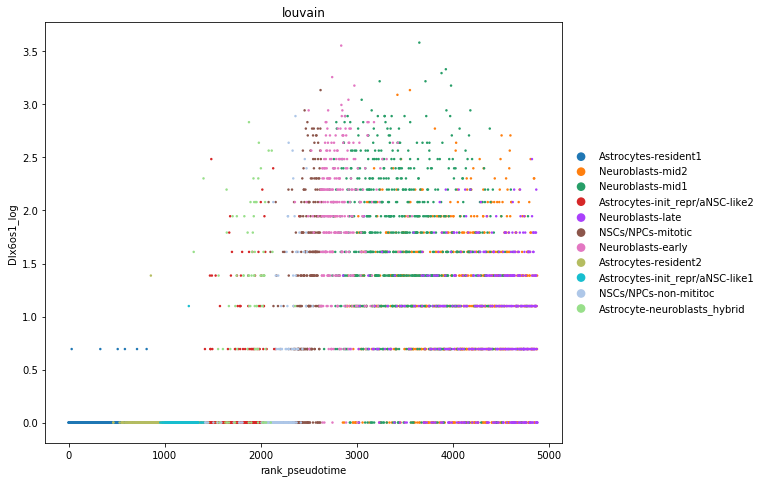

In [88]:
# gene_list = ['Aldh1l1', 'Lenti-hGfa-Dlx2-IRES-GFP', 'Top2a', 'Dlx2', 'Dcx', 'Calb2', 'tdTomato-WPRE-bGHpA']
gene_list = ['Clu', 'Id3', 'Rpl32', 'Egfr', 'Mki67', 'Ccna2', 'Dlx1', 'Dlx2', 'Dcx', 'Dlx6os1']

for gene in gene_list:
    adata_neural_tmp.obs[gene+'_scaled'] = adata_genes.X[np.where(adata_genes.obs.index==gene)].flatten()
    sc.pl.scatter(adata_neural_tmp, x='rank_pseudotime', y=gene+'_scaled', color='louvain', use_raw=False, 
             #save='_mainTraj_Egfr_alongPseudotime.pdf'
             )
    
for gene in gene_list:
    adata_neural_tmp.obs[gene+'_log'] = adata.raw[:,gene].X
    sc.pl.scatter(adata_neural_tmp, x='rank_pseudotime', y=gene+'_log', color='louvain', use_raw=True, 
             #save='_mainTraj_Egfr_alongPseudotime.pdf'
             )

In [89]:
# Write the genes in each cluster into .csv spreadsheets
for n_cluster_gene in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(n_cluster_gene)
    cluster_gene_index = adata_genes.obs[adata_genes.obs['louvain'] == n_cluster_gene].index
    adata_genes.obs.loc[cluster_gene_index].to_csv(out_dir+'gene_clustering/chi-sqaure_2500_louvain_cluster_'+n_cluster_gene+'_gene_list.csv')

## Plot louvain gene clusters along pseudotime

In [90]:
assert 'rank_pseudotime' in adata_neural_tmp.obs.columns

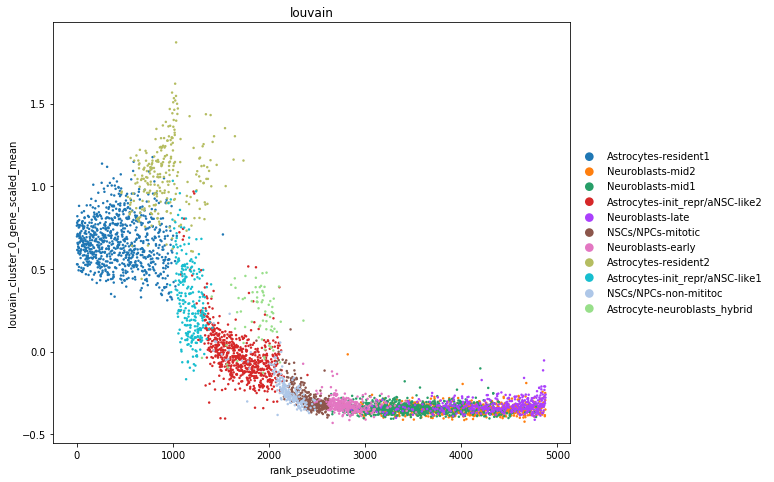

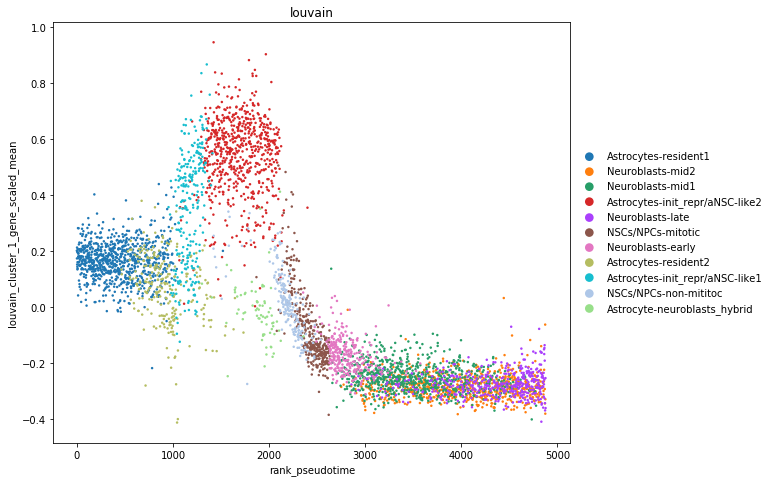

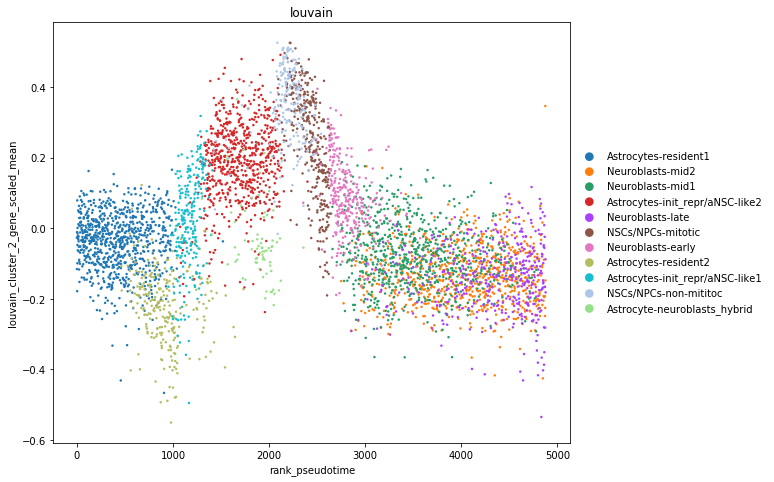

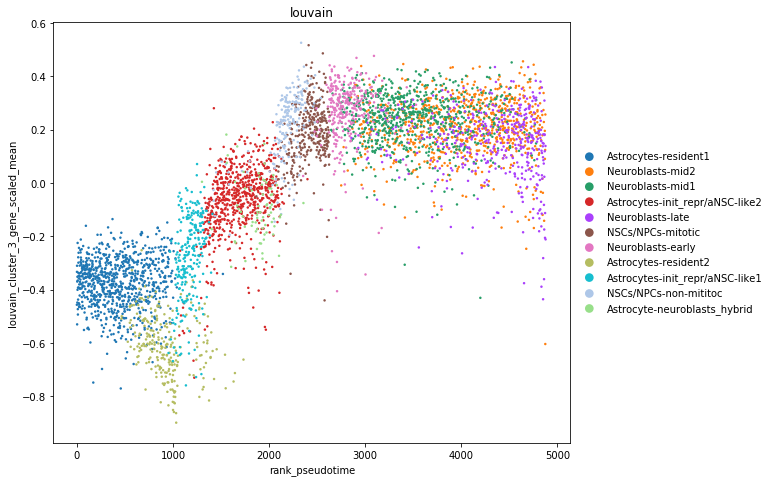

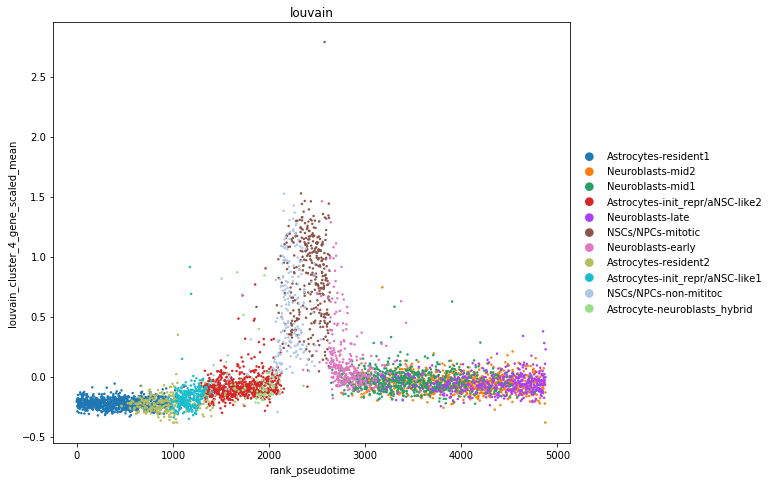

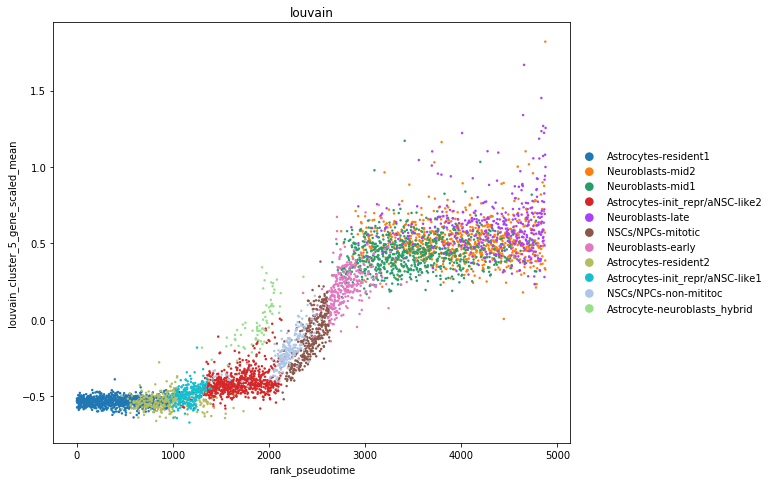

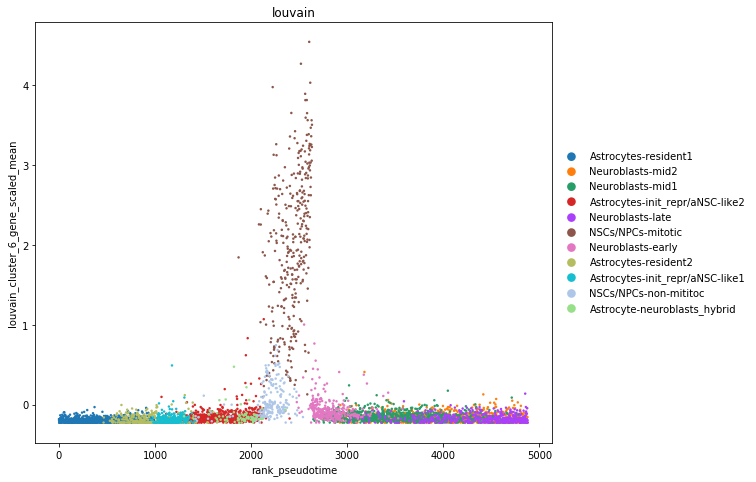

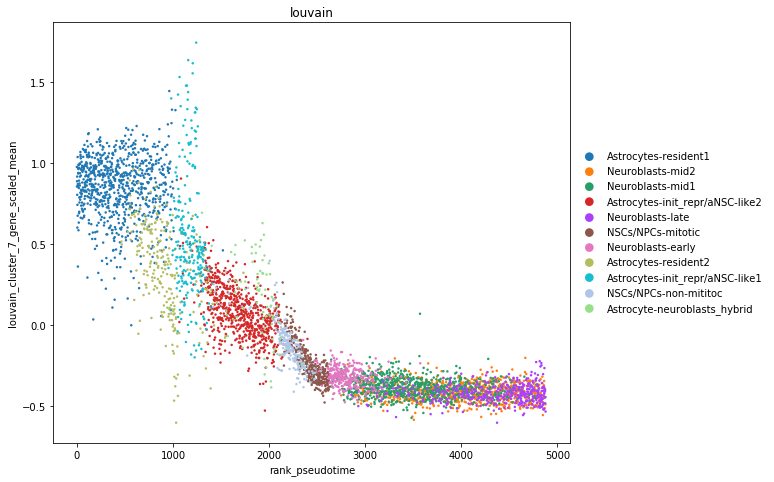

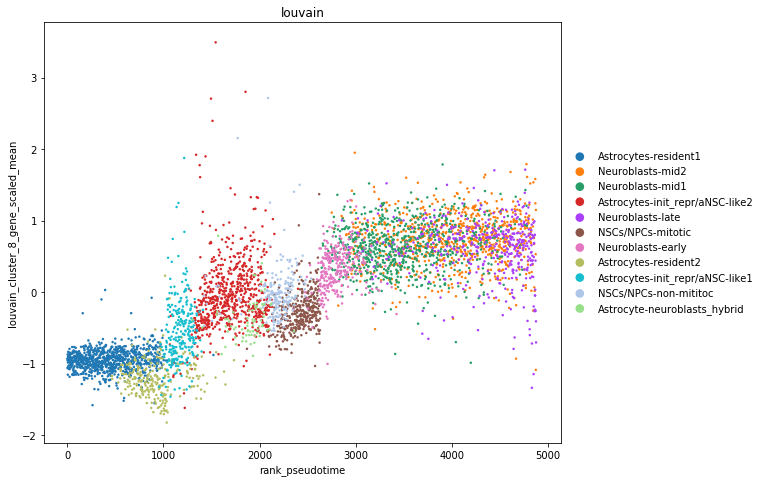

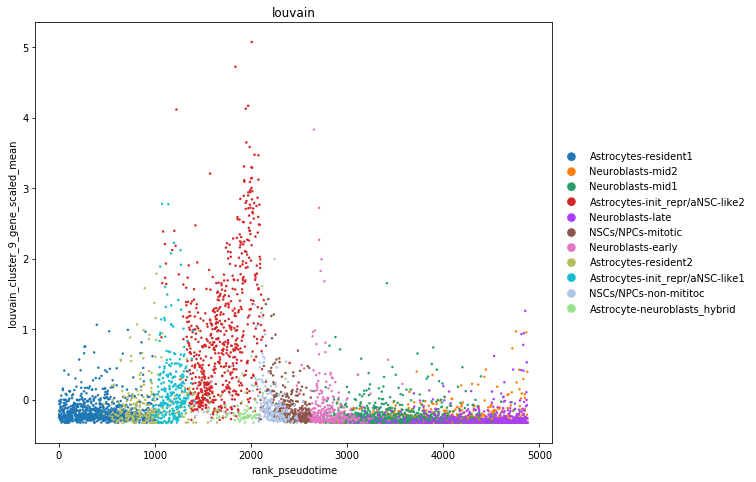

In [91]:
for n_cluster_gene in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(n_cluster_gene)
    sc.pl.scatter(adata_neural_tmp, x='rank_pseudotime', y='louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean', color='louvain', use_raw=True, 
             #save='_mainTraj_Egfr_alongPseudotime.pdf'
             )

#### Calculate LOESS curves for each cluster

##### With scaled mean

In [92]:
gene_louvain_scaled_mean_loess = []
for i in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(i)
    x = adata_neural_tmp.obs['rank_pseudotime']
    y = adata_neural_tmp.obs['louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean']

    gene_louvain_scaled_mean_loess.append(lowess(y, x, frac=0.2)) 

In [93]:
output_path = python_dir + 'gene_louvain_scaled_mean_loess_chiSquare_2500'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(gene_louvain_scaled_mean_loess, output_file)

In [94]:
input_path = python_dir + 'gene_louvain_scaled_mean_loess_chiSquare_2500'
with open(input_path, 'rb') as input_file:
 
    gene_louvain_scaled_mean_loess = pickle.load(input_file)

Current cluster is: 0


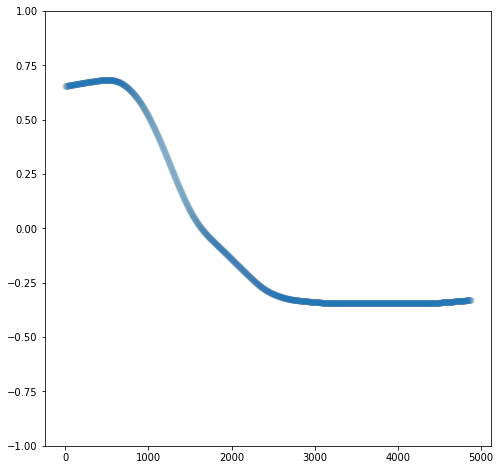

Current cluster is: 1


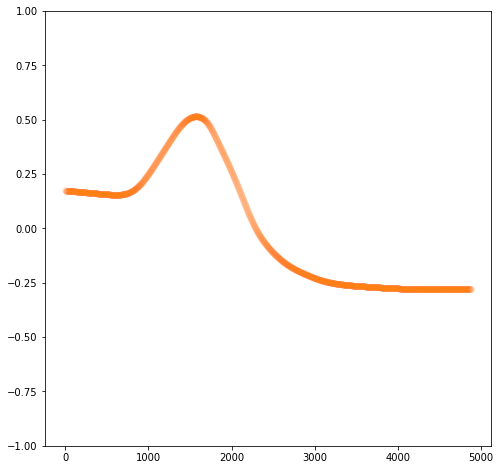

Current cluster is: 2


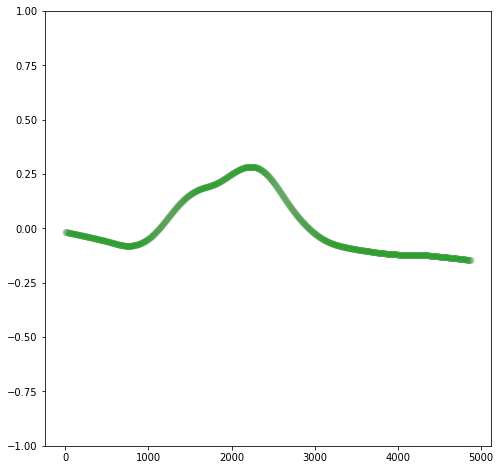

Current cluster is: 3


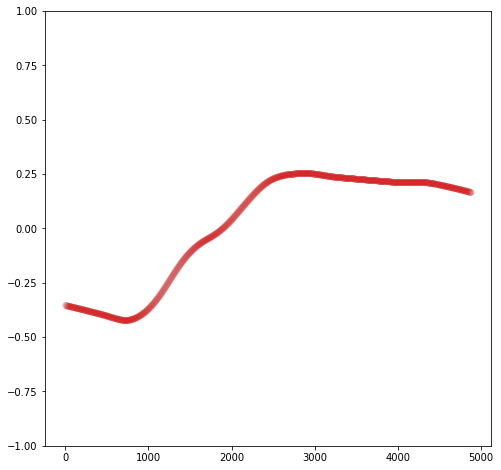

Current cluster is: 4


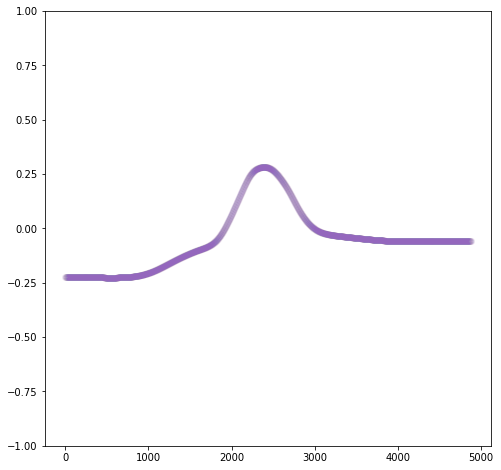

Current cluster is: 5


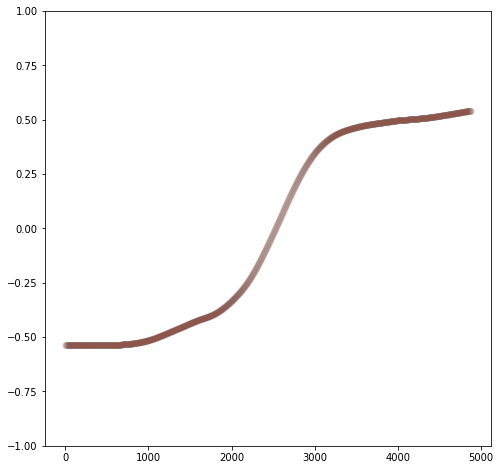

Current cluster is: 6


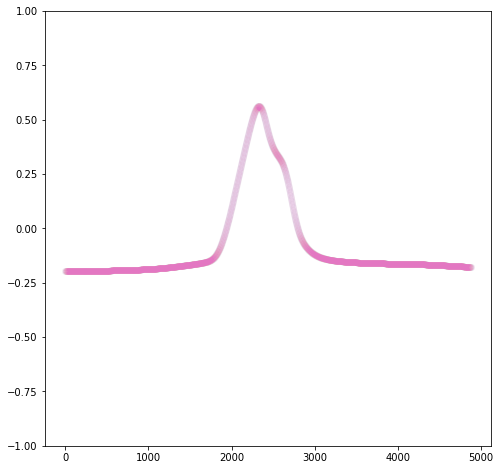

Current cluster is: 7


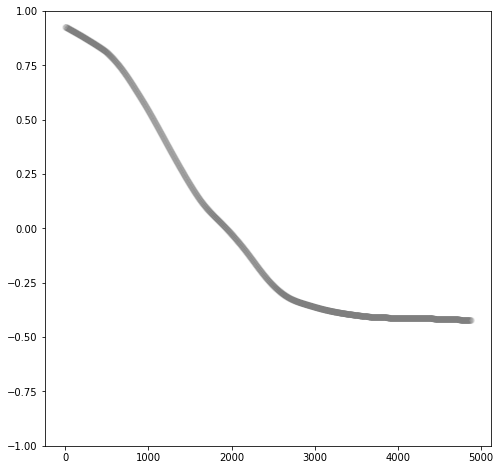

Current cluster is: 8


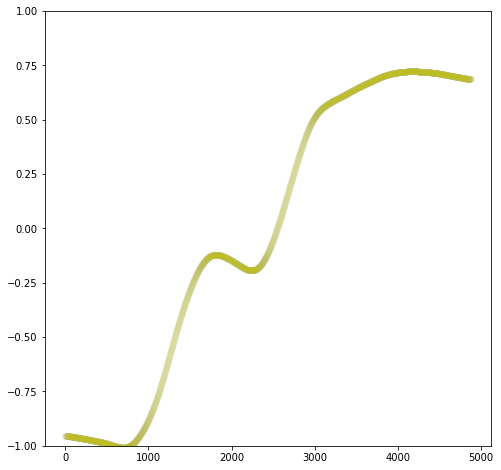

Current cluster is: 9


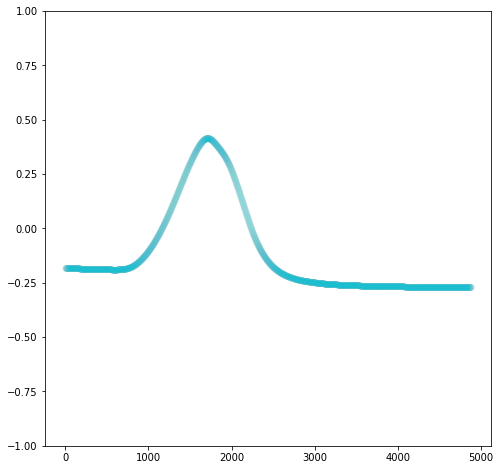

In [95]:
for i in range(len(louvain_clusters_counter)): 
    print('Current cluster is: {}'.format(i))
    plt.scatter(gene_louvain_scaled_mean_loess[i][:,0], gene_louvain_scaled_mean_loess[i][:,1], 
                #s=area, 
#                vmin=-0.8, 
#                vmax=0.8,
                c=adata_genes.uns['louvain_colors'][i],  
                alpha=0.02)
    plt.ylim(-1.0, 1.0)
    plt.show()    

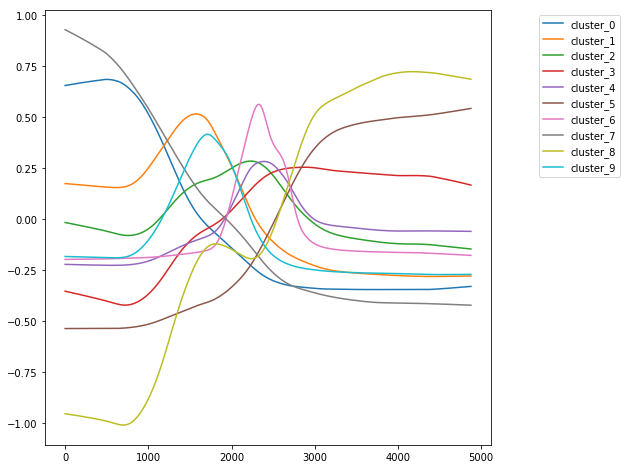

In [96]:
handles = []
for i in range(len(louvain_clusters_counter)): 
#    print('Current cluster is: {}'.format(i))
    clr = adata_genes.uns['louvain_colors'][i]
    plt.plot(gene_louvain_scaled_mean_loess[i][:,0], gene_louvain_scaled_mean_loess[i][:,1], 
             clr,
             alpha=1, 
             linestyle='-'
             )
    handles.append(mpl.lines.Line2D([], [], color=clr, linestyle='-', label='cluster_'+str(i)))

plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1))
    
# plt.legend()
plt.show()    

In [97]:
len(gene_louvain_scaled_mean_loess)

10

In [98]:
# What cutoff to use? Either one is justifiable. 
# 0.147 cutoff is to include cluster 12, since Egfr is in that cluster
gene_louvain_oi = []
for i in range(len(gene_louvain_scaled_mean_loess)):
#    if gene_louvain_scaled_mean_loess[i][:,1].max() - gene_louvain_scaled_mean_loess[i][:,1].min() > 0.147:
    if gene_louvain_scaled_mean_loess[i][:,1].max() - gene_louvain_scaled_mean_loess[i][:,1].min() > 0.25:
        print(i)
        gene_louvain_oi.append(i)

0
1
2
3
4
5
6
7
8
9


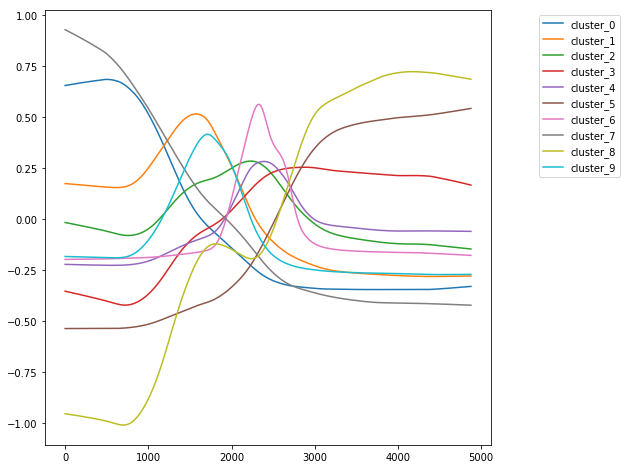

In [99]:
handles = []
for i in gene_louvain_oi: 
#    print('Current cluster is: {}'.format(i))
    clr = adata_genes.uns['louvain_colors'][i]
    plt.plot(gene_louvain_scaled_mean_loess[i][:,0], gene_louvain_scaled_mean_loess[i][:,1], 
             clr,
             alpha=1, 
             linestyle='-'
             )
    handles.append(mpl.lines.Line2D([], [], color=clr, linestyle='-', label='cluster_'+str(i)))

plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1))
    
# plt.legend()
plt.show()    

In [100]:
cluster_oi = [str(cluster) for cluster in gene_louvain_oi]

In [101]:
sum(adata_genes.obs['louvain'].isin(cluster_oi))

2445

In [102]:
adata_genes.obs['louvain'].value_counts()[cluster_oi]

0    481
1    364
2    330
3    308
4    299
5    266
6    144
7    115
8     76
9     62
Name: louvain, dtype: int64

In [106]:
for gene in adata_genes.obs.index[adata_genes.obs['louvain'] == '9'].tolist():
    print(gene)

Stat1
Serping1
Ube2l6
B2m
Zbp1
Gbp5
Gbp7
Gbp3
Gbp2
Ifi44
Isg15
Gbp8
Gbp9
Gbp4
Oasl2
Samd9l
Herc6
Tapbpl
Trim30a
Ifitm3
Irf7
Bst2
Psmb10
Irgm1
Ifi47
Igtp
Irgm2
Xaf1
Slfn8
Rnf213
Ly6e
Ly6a
Tspo
Rtp4
Parp14
Parp9
H2-K1
H2-DMa
H2-DMb1
Psmb9
Tap1
Psmb8
Tap2
H2-Ab1
H2-Aa
H2-Eb1
H2-D1
H2-Q4
H2-Q6
H2-Q7
H2-T23
H2-T22
H2-M3
Eif2ak2
Gm4951
Gm4841
F830016B08Rik
Iigp1
Cd74
Ifit3
Ifit3b
Ifit1


### Saving the data

In [107]:
gene_data_dir

'/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/Gene_clusters/'

In [108]:
adata_neural_tmp.write(gene_data_dir + 'adata_neural_BLOnly_geneClusters_ChiSquare_2500.h5ad')

In [9]:
adata_neural_tmp = sc.read(gene_data_dir + 'adata_neural_BLOnly_geneClusters_ChiSquare_2500.h5ad')

In [110]:
output_path = gene_data_dir + 'adata_genes_ChiSquare_2500'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(adata_genes, output_file)

In [10]:
input_path = gene_data_dir + 'adata_genes_ChiSquare_2500'
with open(input_path, 'rb') as input_file:
 
    adata_genes = pickle.load(input_file)

In [11]:
adata_genes

AnnData object with n_obs × n_vars = 2445 × 4879 
    obs: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts', 'n_cells_BL_neural', 'louvain', 'log10_n_cells_BL_neural'
    var: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    uns: 'pca', 'neighbors', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

### Plot the densest and sparsest genes in each cluster and see if they agree with the average trend

Current cluster is: 0


/home2/s418610/.conda/envs/py37_TOC_PAGA/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


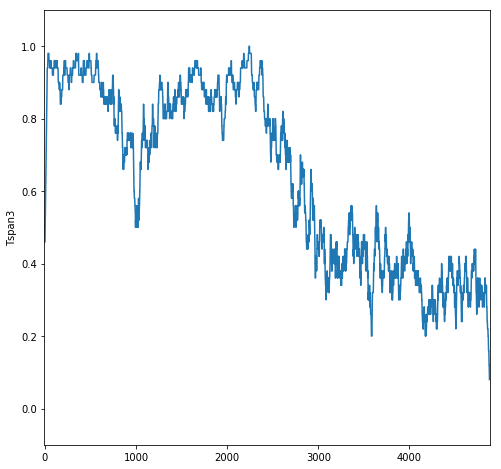

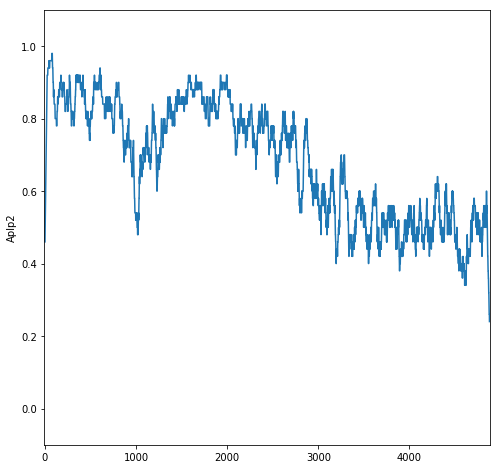

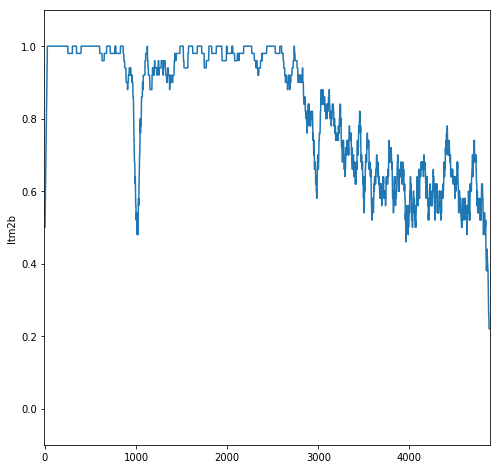

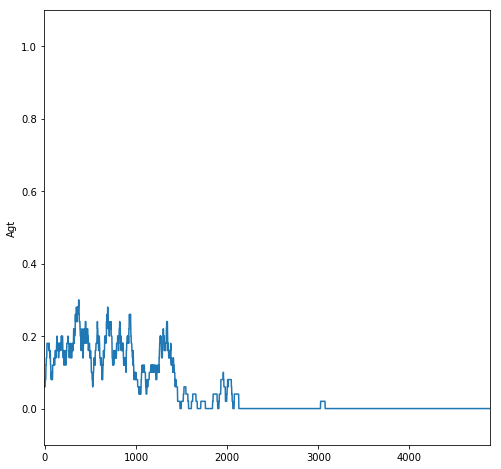

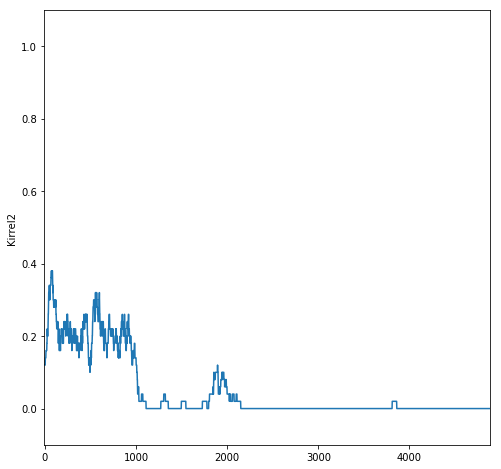

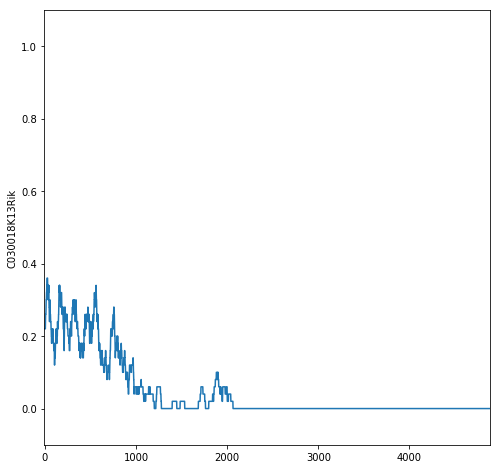

Current cluster is: 1


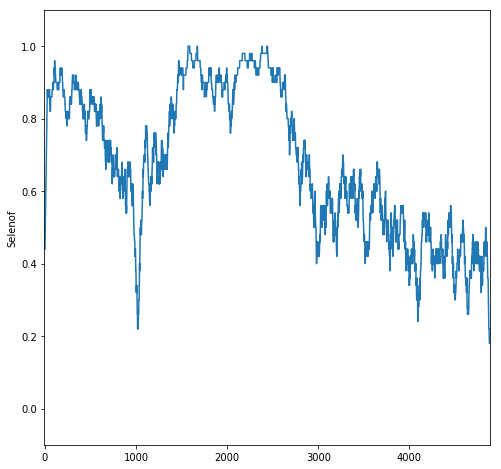

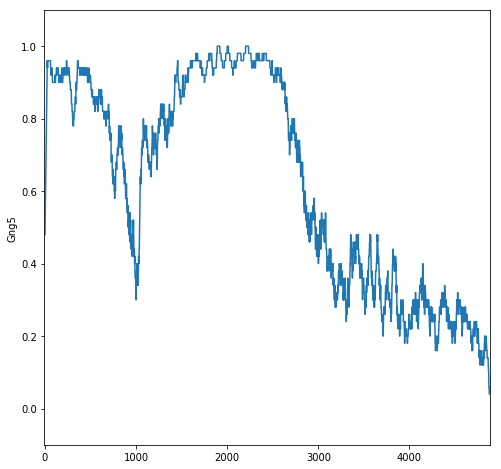

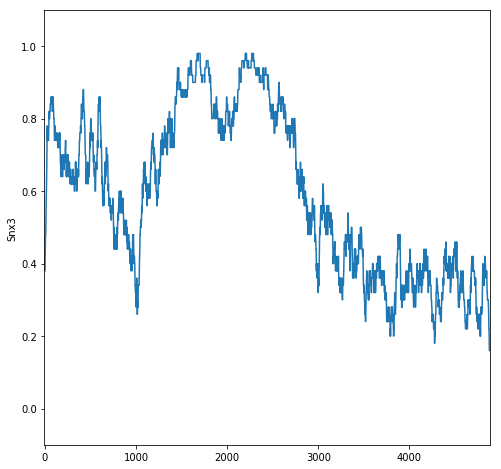

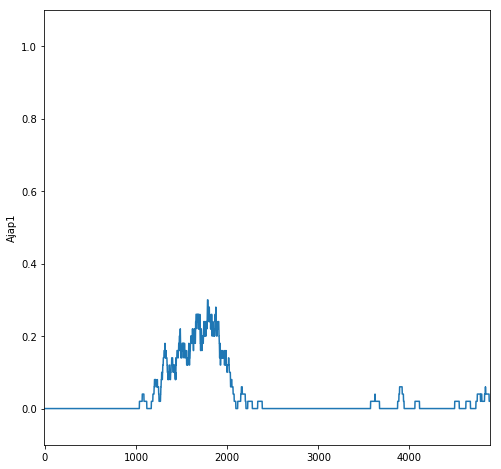

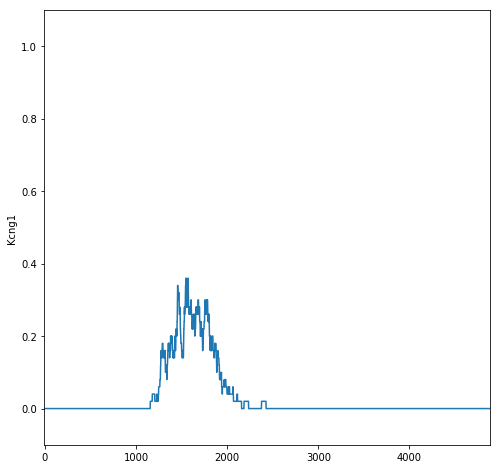

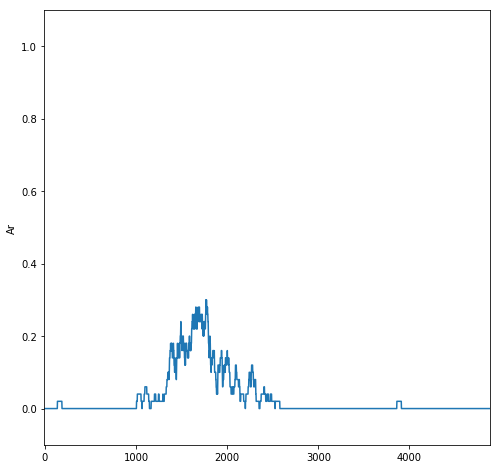

Current cluster is: 2


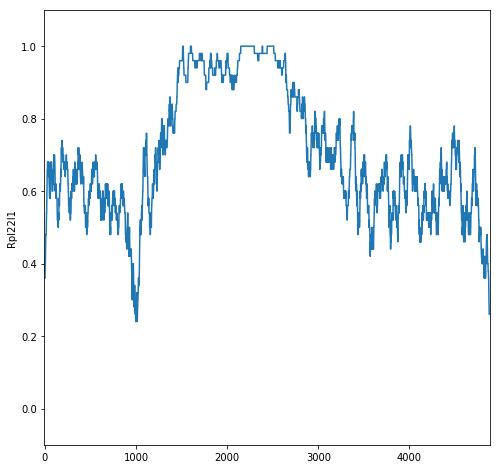

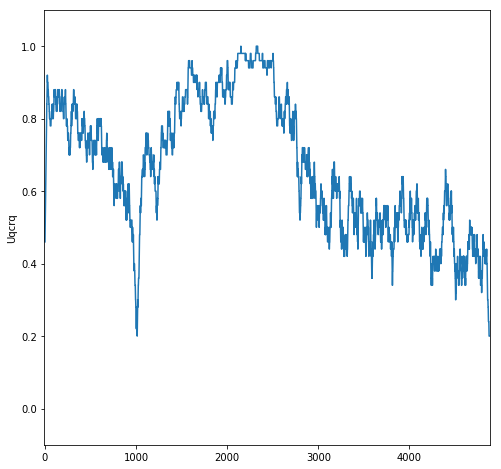

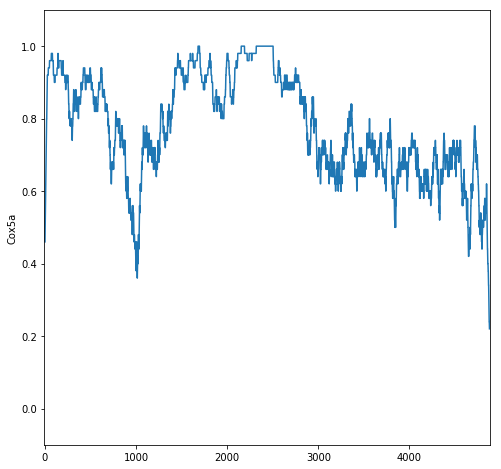

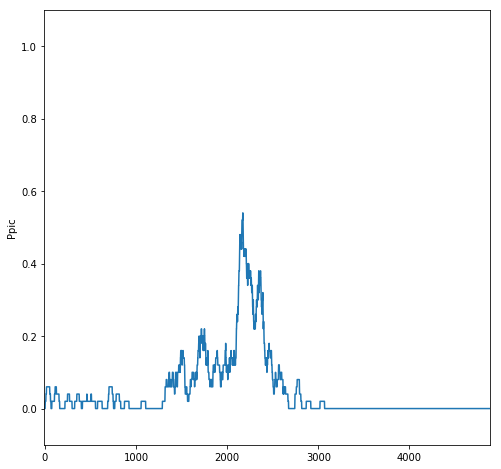

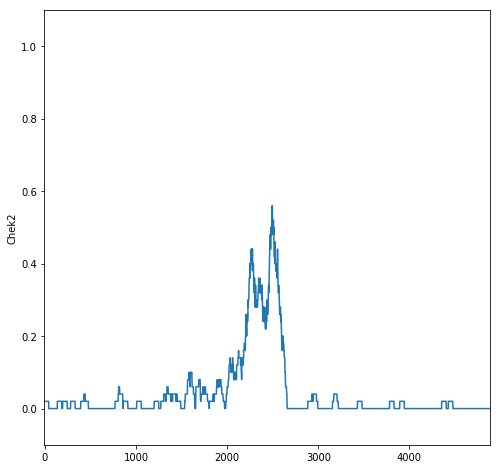

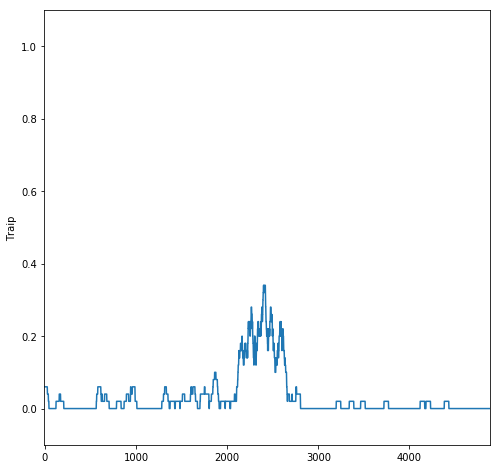

Current cluster is: 3


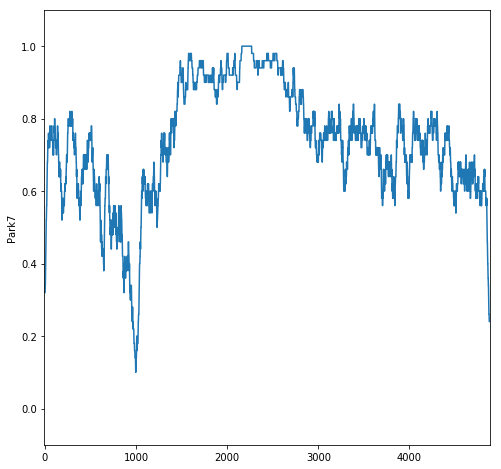

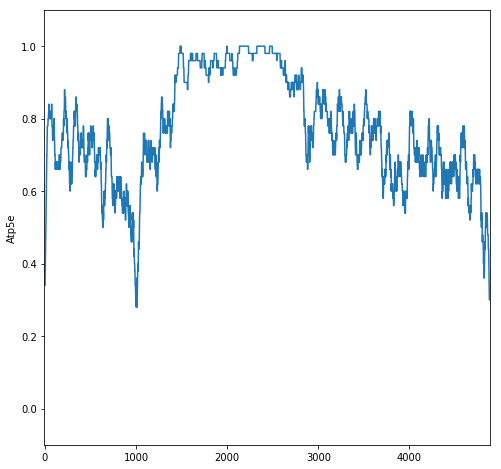

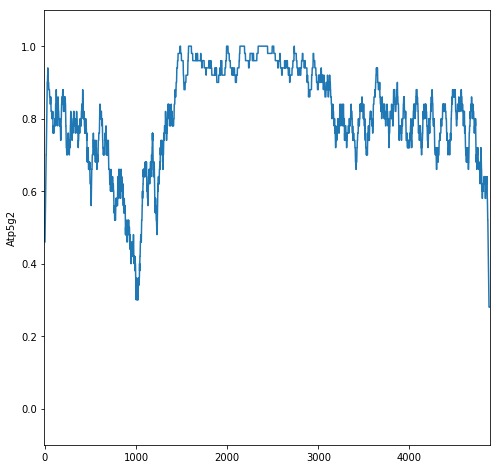

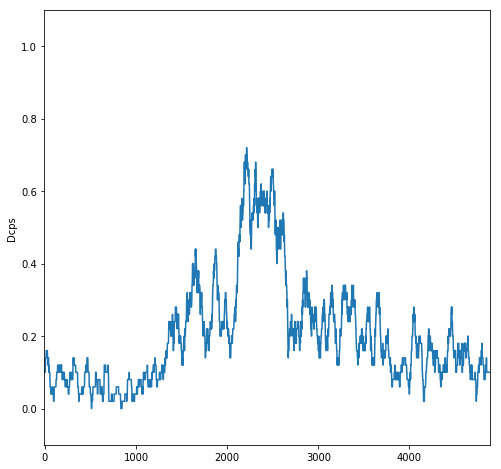

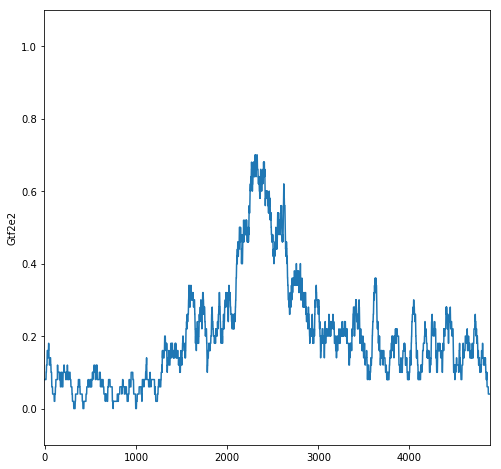

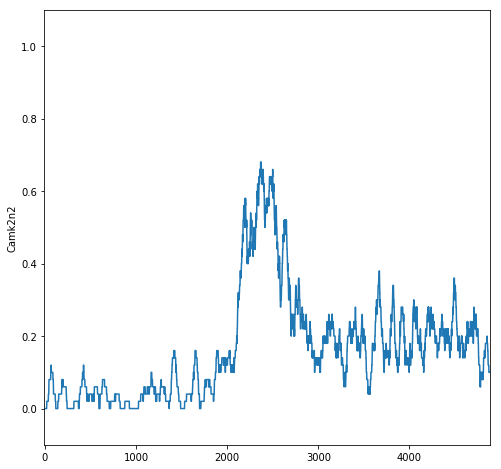

Current cluster is: 4


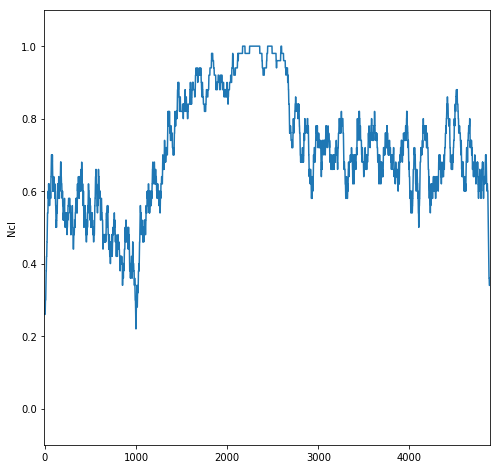

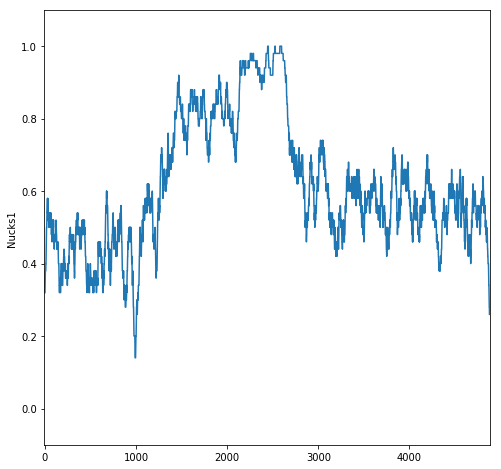

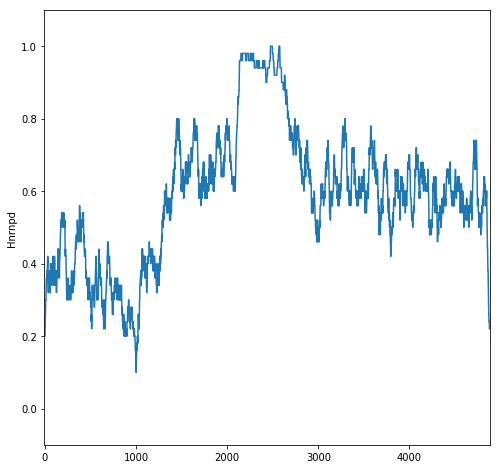

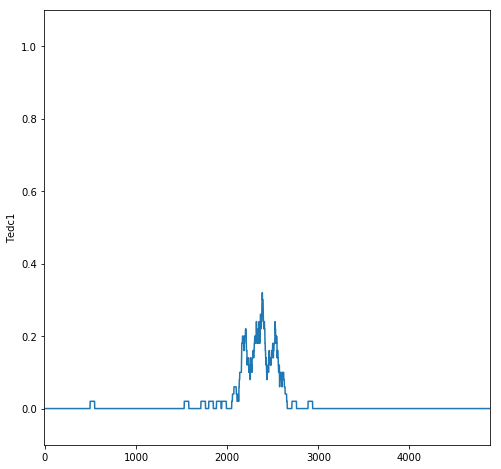

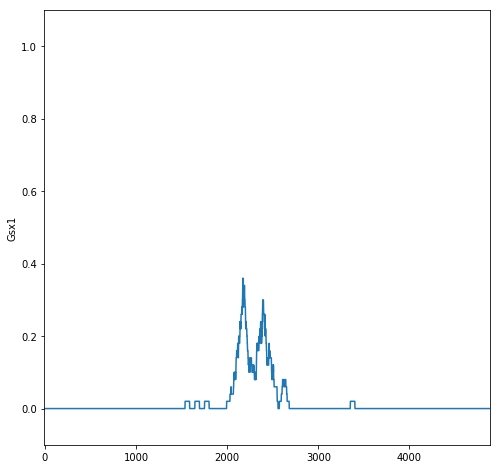

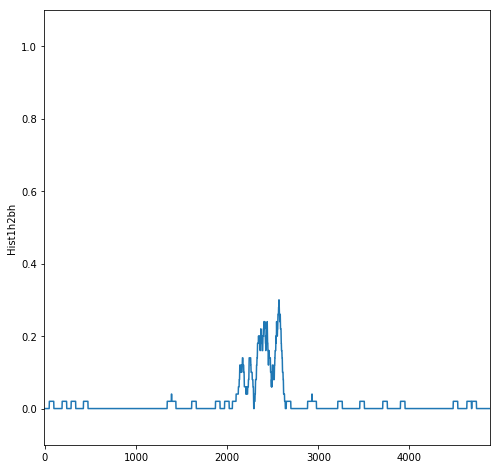

Current cluster is: 5


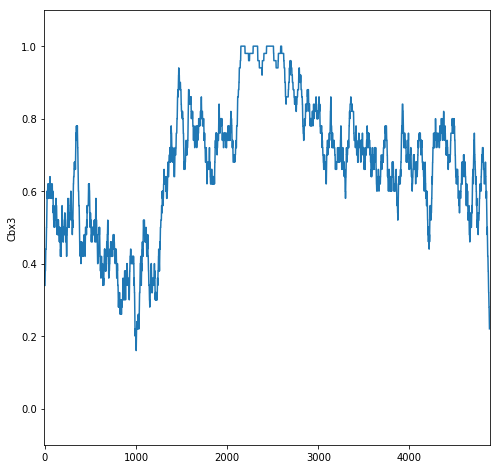

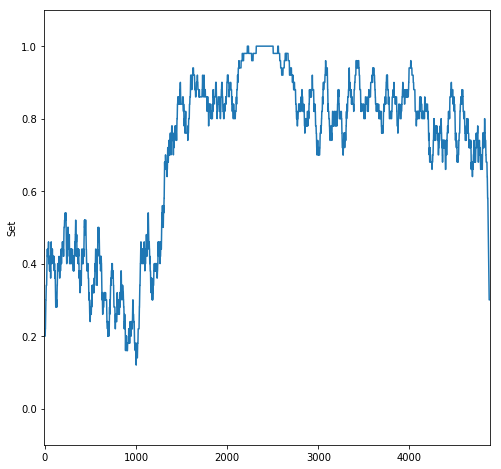

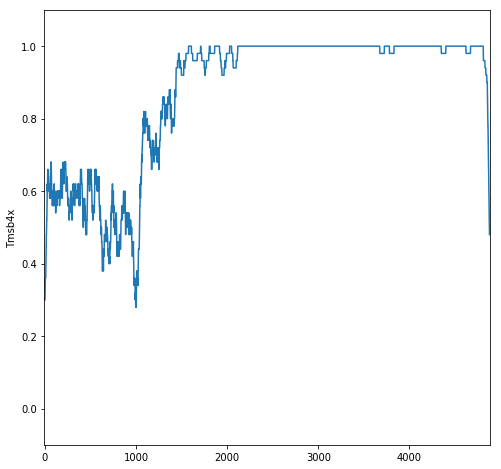

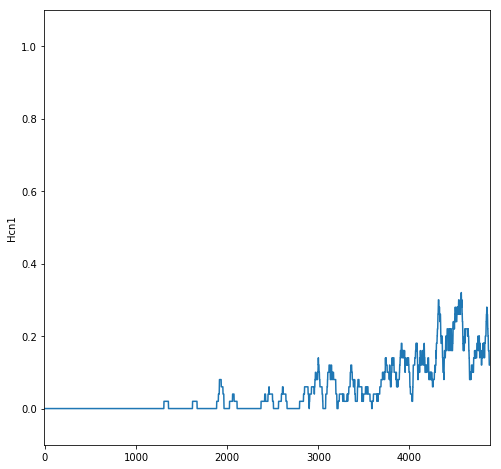

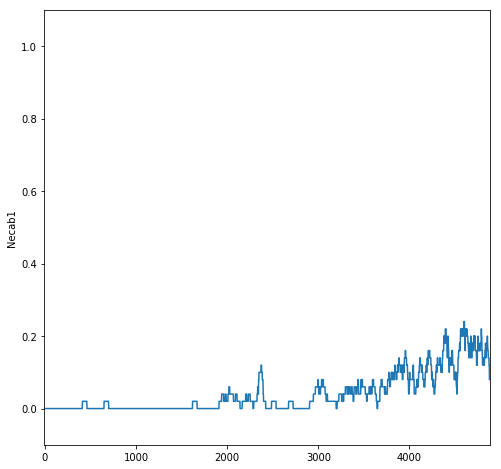

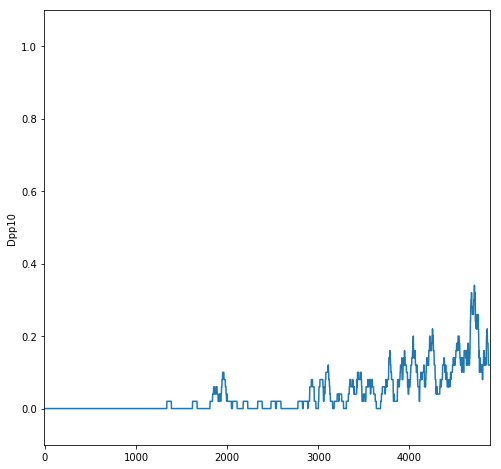

Current cluster is: 6


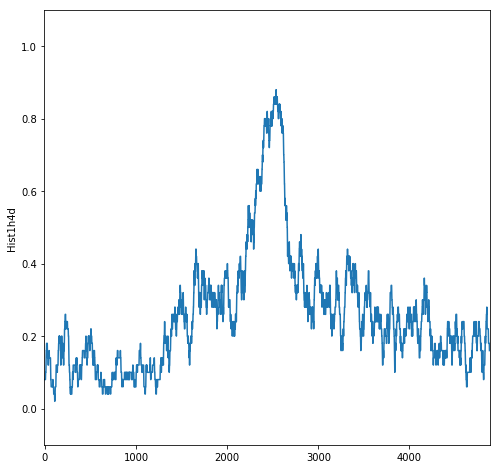

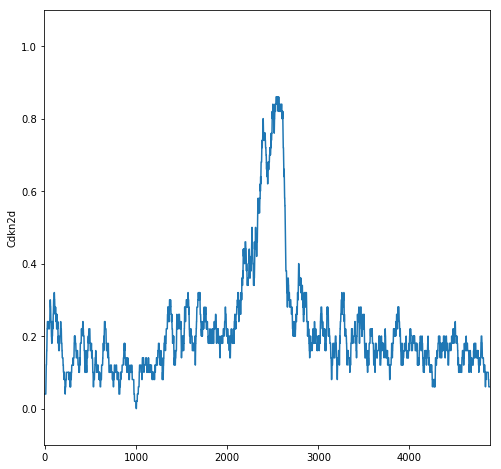

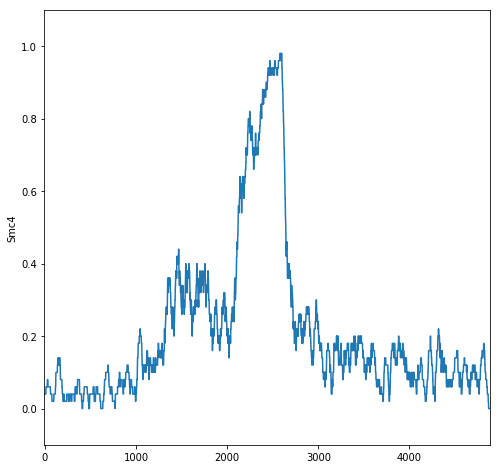

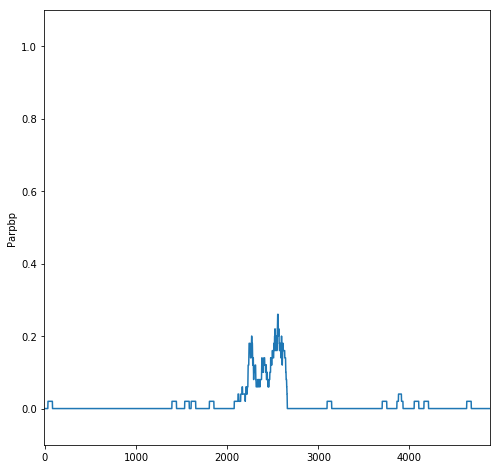

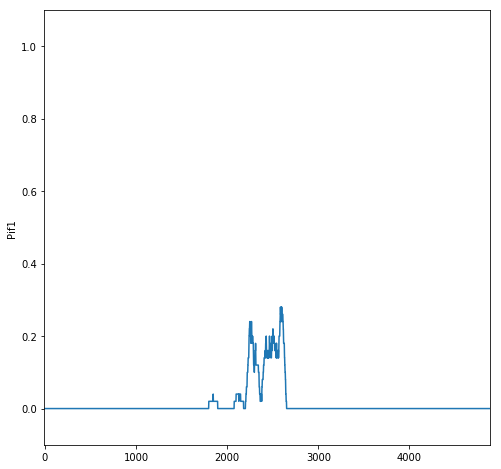

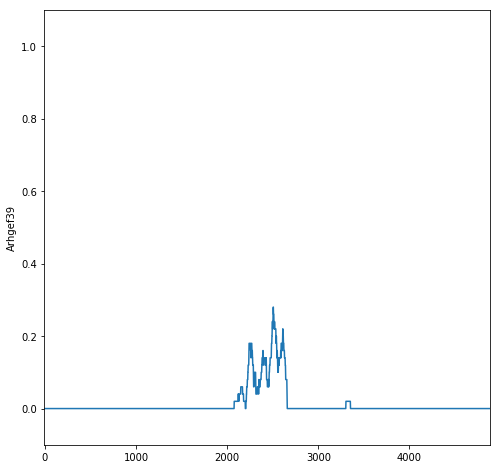

Current cluster is: 7


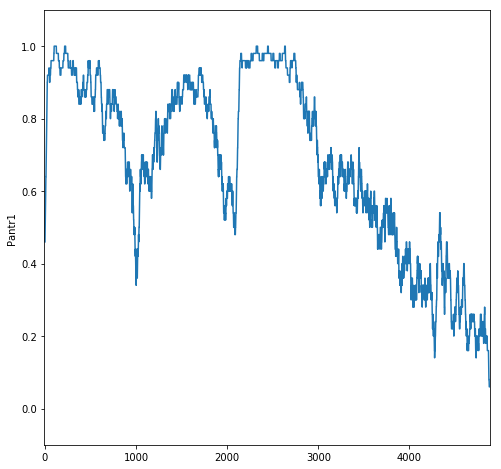

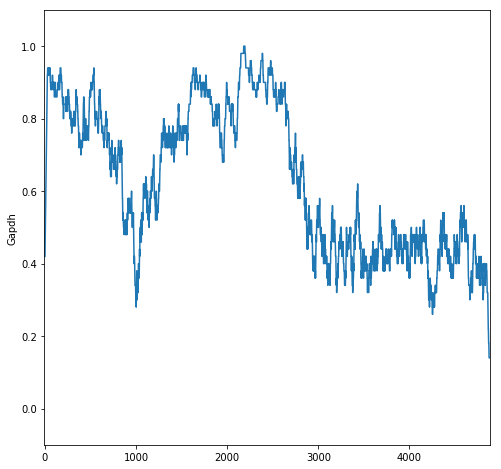

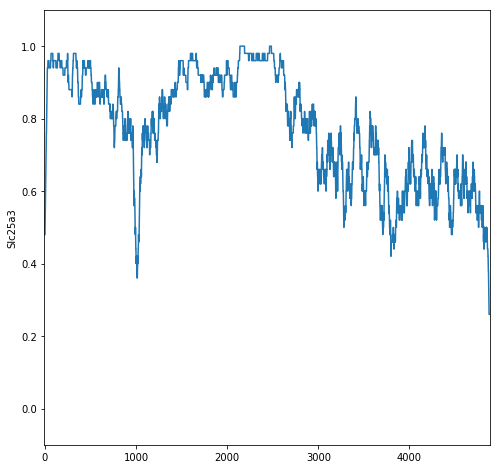

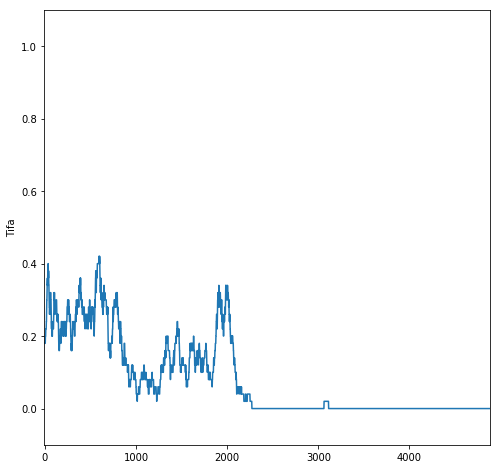

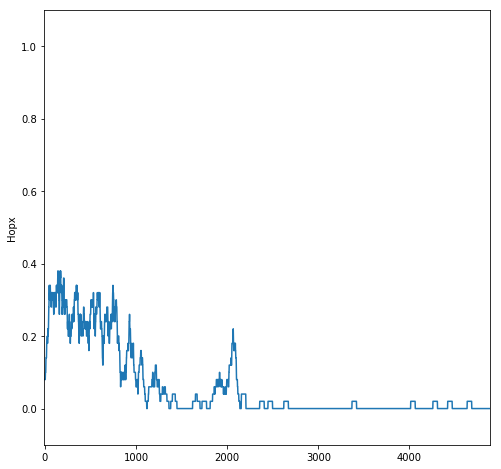

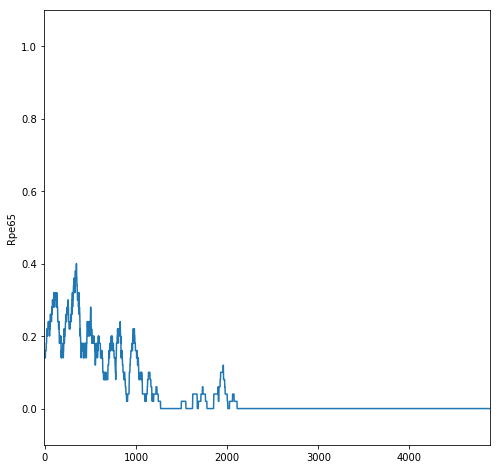

Current cluster is: 8


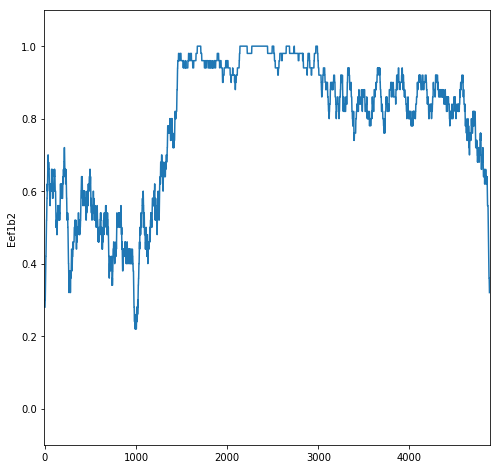

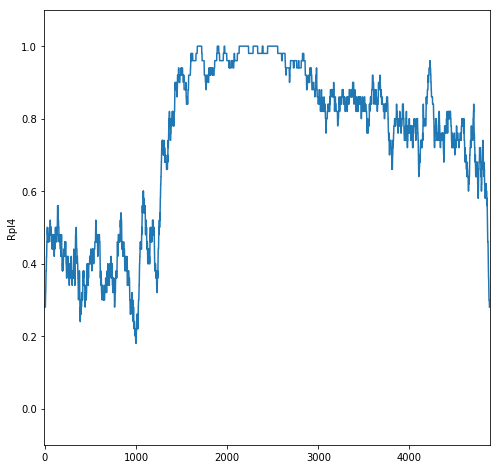

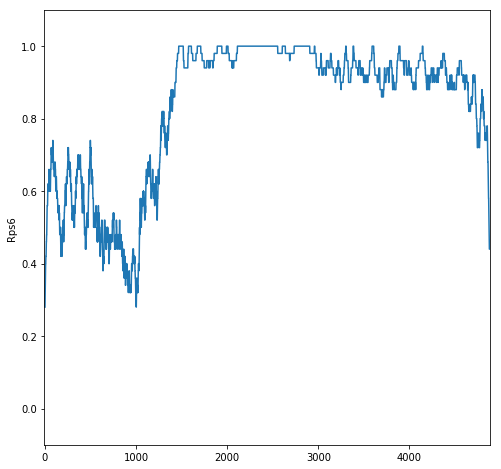

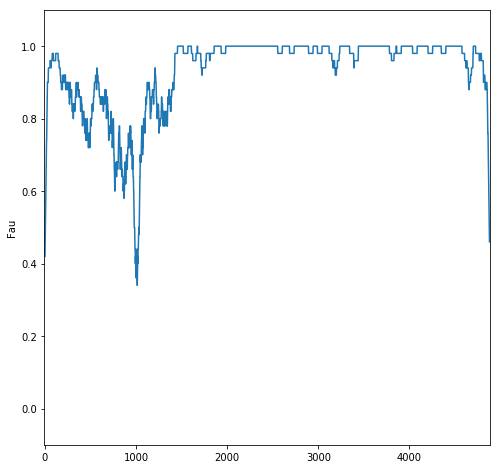

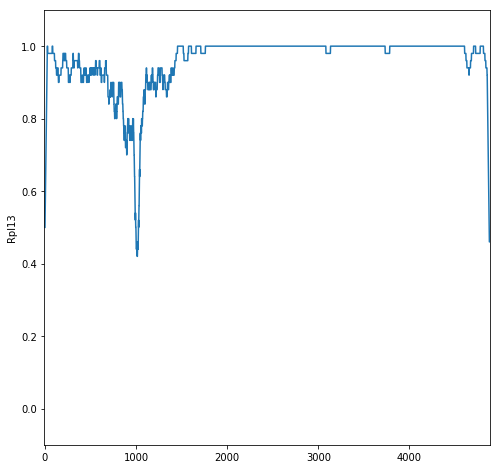

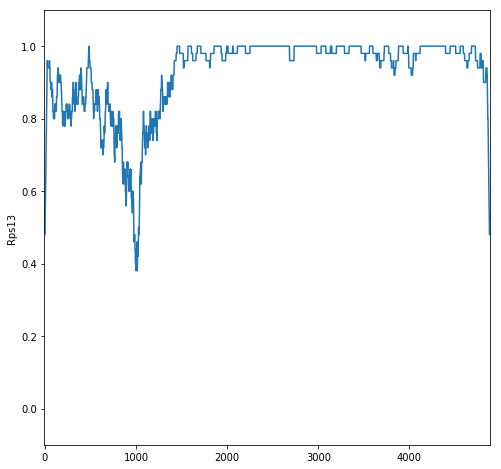

Current cluster is: 9


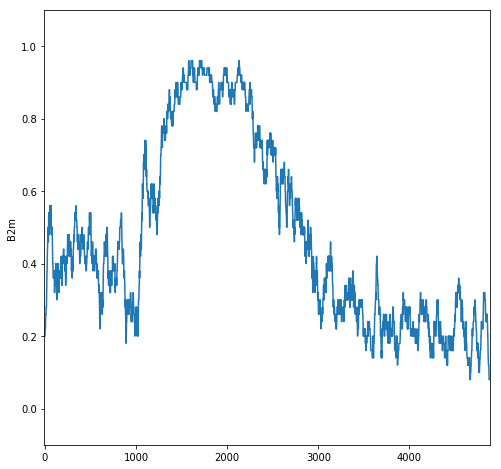

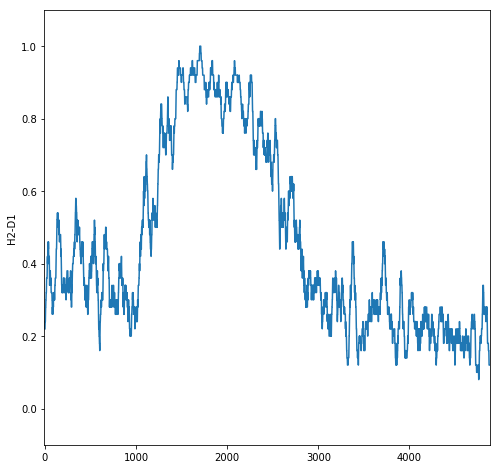

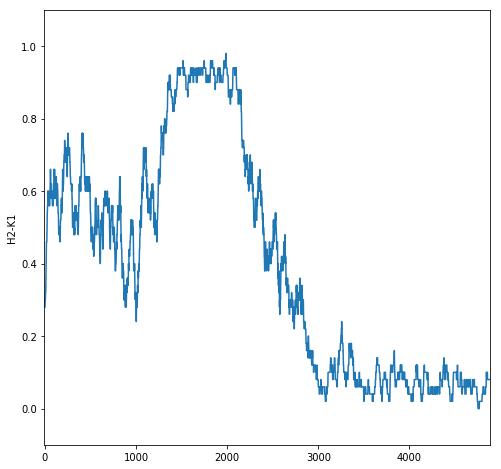

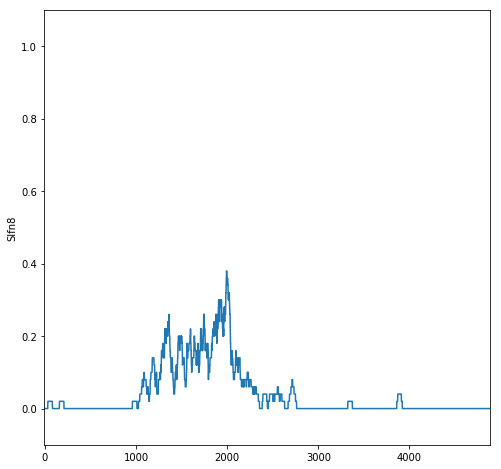

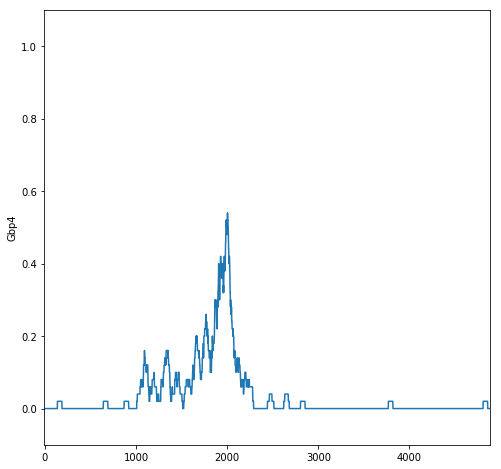

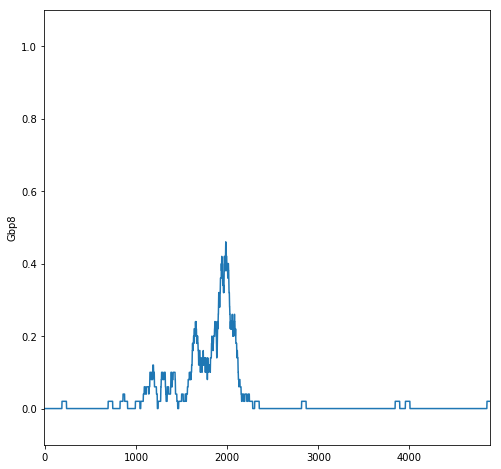

In [157]:
for current_cluster in cluster_oi:

    print('Current cluster is: {}'.format(current_cluster))

    # adata_genes.obs[np.where(adata_genes.obs['louvain']==current_cluster, True, False)]

    # pd.DataFrame.sort_values(adata_genes.obs[np.where(adata_genes.obs['louvain']==current_cluster, True, False)], by='n_cells_BL_neural', ascending=False)[-3:]

    gene_list = pd.DataFrame.sort_values(adata_genes.obs[np.where(adata_genes.obs['louvain']==current_cluster, True, False)], by='n_cells_BL_neural', ascending=False)[:3].index.tolist()

    for gene in gene_list:
        df_plot = pd.DataFrame(data={'rank_pseudotime': adata.obs['rank_pseudotime'], 'gene_is_expressed': np.where(adata.raw[:,gene].X > 0, 1, 0)})

        df_plot.sort_values(by='rank_pseudotime', axis=0, ascending=True, inplace=True)

        plt.plot(df_plot['rank_pseudotime'], 
                 np.convolve(df_plot['gene_is_expressed'], np.ones((50,))/50, mode='same') )
        plt.axis([-10, 4889, -.1, 1.1])
        plt.ylabel(gene)
        plt.show()

    
    gene_list = pd.DataFrame.sort_values(adata_genes.obs[np.where(adata_genes.obs['louvain']==current_cluster, True, False)], by='n_cells_BL_neural', ascending=False)[-3:].index.tolist()
    for gene in gene_list: 
        df_plot = pd.DataFrame(data={'rank_pseudotime': adata.obs['rank_pseudotime'], 'gene_is_expressed': np.where(adata.raw[:,gene].X > 0, 1, 0)})

        df_plot.sort_values(by='rank_pseudotime', axis=0, ascending=True, inplace=True)

        plt.plot(df_plot['rank_pseudotime'], 
                 np.convolve(df_plot['gene_is_expressed'], np.ones((50,))/50, mode='same') )
        plt.axis([-10, 4889, -.1, 1.1])
        plt.ylabel(gene)
        plt.show()